In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        return logits

In [6]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        return logits

In [7]:
def model_loss(state_size, action_size, hidden_size, 
               states, actions, next_states, rewards, dones, rates):
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ###############################################
    next_states_logits = generator(actions=actions_logits, hidden_size=hidden_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    aloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, 
                                                                    labels=next_states_labels))
    ####################################################
    Qs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, action_size=action_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, # GAN
                                                                   labels=rates)) # 0-1
    ############################################################################
    next_actions_logits = actor(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    nextQs_logits = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states, 
                                  action_size=action_size, reuse=True)
    nextQs = tf.reshape(nextQs_logits, shape=[-1]) * (1-dones)
    targetQs = rewards + (0.99 * nextQs)
    aloss2 = tf.reduce_mean(tf.square(Qs - targetQs)) # DQN
    return actions_logits, aloss, dloss, aloss2

In [8]:
def model_opt(a_loss, a_loss2, d_loss, a_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('actor')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, d_opt, a_opt2

In [9]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.d_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, #model input 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.d_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        a_loss2=self.a_loss2, 
                                                        d_loss=self.d_loss,
                                                        a_learning_rate=a_learning_rate,
                                                        d_learning_rate=d_learning_rate)

In [10]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [11]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [12]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [13]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [14]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# aloss_list, dloss_list, aloss2_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        aloss_batch, dloss_batch, aloss2_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 1.0
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            aloss, dloss, _, _ = sess.run([model.a_loss, model.d_loss, model.a_opt, model.d_opt],
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.next_states: next_states,
                                                       model.rewards: rewards,
                                                       model.dones: dones,
                                                       model.rates: rates})
            aloss2, _ = sess.run([model.a_loss2, model.a_opt2], 
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.next_states: next_states,
                                                       model.rewards: rewards,
                                                       model.dones: dones,
                                                       model.rates: rates})
            aloss_batch.append(aloss)
            dloss_batch.append(dloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:20.0000 R:20.0000 rate:0.0400 aloss:1.4323 dloss:0.7676 aloss2:0.6770 exploreP:0.9980
Episode:1 meanR:20.0000 R:20.0000 rate:0.0400 aloss:1.4279 dloss:0.7633 aloss2:0.6859 exploreP:0.9960
Episode:2 meanR:26.6667 R:40.0000 rate:0.0800 aloss:1.4170 dloss:0.7485 aloss2:0.7142 exploreP:0.9921
Episode:3 meanR:24.2500 R:17.0000 rate:0.0340 aloss:1.4093 dloss:0.7404 aloss2:0.7274 exploreP:0.9904
Episode:4 meanR:22.4000 R:15.0000 rate:0.0300 aloss:1.3989 dloss:0.7361 aloss2:0.7155 exploreP:0.9890
Episode:5 meanR:21.0000 R:14.0000 rate:0.0280 aloss:1.4015 dloss:0.7342 aloss2:0.7012 exploreP:0.9876
Episode:6 meanR:20.2857 R:16.0000 rate:0.0320 aloss:1.3974 dloss:0.7234 aloss2:0.7376 exploreP:0.9860
Episode:7 meanR:19.6250 R:15.0000 rate:0.0300 aloss:1.4005 dloss:0.7229 aloss2:0.7175 exploreP:0.9846
Episode:8 meanR:19.6667 R:20.0000 rate:0.0400 aloss:1.3872 dloss:0.7042 aloss2:0.7900 exploreP:0.9826
Episode:9 meanR:19.2000 R:15.0000 rate:0.0300 aloss:1.3959 dloss:0.7079 aloss2:0.7

Episode:80 meanR:22.2469 R:14.0000 rate:0.0280 aloss:1.4212 dloss:0.4227 aloss2:1.2746 exploreP:0.8368
Episode:81 meanR:22.2805 R:25.0000 rate:0.0500 aloss:1.4347 dloss:0.4221 aloss2:1.2780 exploreP:0.8347
Episode:82 meanR:22.4217 R:34.0000 rate:0.0680 aloss:1.4074 dloss:0.4197 aloss2:1.2994 exploreP:0.8319
Episode:83 meanR:22.4762 R:27.0000 rate:0.0540 aloss:1.3970 dloss:0.4187 aloss2:1.4988 exploreP:0.8297
Episode:84 meanR:22.4353 R:19.0000 rate:0.0380 aloss:1.4379 dloss:0.4184 aloss2:1.2639 exploreP:0.8281
Episode:85 meanR:22.3140 R:12.0000 rate:0.0240 aloss:1.4199 dloss:0.4213 aloss2:1.3081 exploreP:0.8271
Episode:86 meanR:22.2184 R:14.0000 rate:0.0280 aloss:1.3974 dloss:0.4117 aloss2:1.2861 exploreP:0.8260
Episode:87 meanR:22.1591 R:17.0000 rate:0.0340 aloss:1.4201 dloss:0.4142 aloss2:1.2696 exploreP:0.8246
Episode:88 meanR:22.0899 R:16.0000 rate:0.0320 aloss:1.4147 dloss:0.4202 aloss2:1.2522 exploreP:0.8233
Episode:89 meanR:21.9889 R:13.0000 rate:0.0260 aloss:1.4078 dloss:0.3904 

Episode:159 meanR:40.8300 R:87.0000 rate:0.1740 aloss:1.3650 dloss:0.3984 aloss2:0.1683 exploreP:0.5869
Episode:160 meanR:41.1400 R:49.0000 rate:0.0980 aloss:1.3656 dloss:0.3815 aloss2:0.1717 exploreP:0.5840
Episode:161 meanR:42.3100 R:128.0000 rate:0.2560 aloss:1.3674 dloss:0.3937 aloss2:0.1973 exploreP:0.5767
Episode:162 meanR:42.6300 R:46.0000 rate:0.0920 aloss:1.3677 dloss:0.3927 aloss2:0.1588 exploreP:0.5741
Episode:163 meanR:43.6900 R:122.0000 rate:0.2440 aloss:1.3639 dloss:0.3788 aloss2:0.1601 exploreP:0.5673
Episode:164 meanR:44.6500 R:113.0000 rate:0.2260 aloss:1.3622 dloss:0.4053 aloss2:0.1567 exploreP:0.5610
Episode:165 meanR:45.1000 R:84.0000 rate:0.1680 aloss:1.3701 dloss:0.3899 aloss2:0.1704 exploreP:0.5564
Episode:166 meanR:46.7000 R:208.0000 rate:0.4160 aloss:1.3643 dloss:0.3947 aloss2:0.1710 exploreP:0.5452
Episode:167 meanR:48.1200 R:152.0000 rate:0.3040 aloss:1.3637 dloss:0.3986 aloss2:0.1528 exploreP:0.5371
Episode:168 meanR:49.3400 R:143.0000 rate:0.2860 aloss:1.36

Episode:237 meanR:207.4200 R:500.0000 rate:1.0000 aloss:1.3520 dloss:0.5764 aloss2:0.1073 exploreP:0.0944
Episode:238 meanR:212.1200 R:500.0000 rate:1.0000 aloss:1.3524 dloss:0.5566 aloss2:0.1168 exploreP:0.0903
Episode:239 meanR:215.9000 R:500.0000 rate:1.0000 aloss:1.3565 dloss:0.5607 aloss2:0.1173 exploreP:0.0864
Episode:240 meanR:219.7000 R:500.0000 rate:1.0000 aloss:1.3551 dloss:0.5706 aloss2:0.1145 exploreP:0.0826
Episode:241 meanR:221.3400 R:193.0000 rate:0.3860 aloss:1.3578 dloss:0.5990 aloss2:0.1315 exploreP:0.0813
Episode:242 meanR:222.1500 R:162.0000 rate:0.3240 aloss:1.3587 dloss:0.5930 aloss2:0.1168 exploreP:0.0801
Episode:243 meanR:224.5600 R:258.0000 rate:0.5160 aloss:1.3580 dloss:0.5813 aloss2:0.1180 exploreP:0.0783
Episode:244 meanR:227.2800 R:425.0000 rate:0.8500 aloss:1.3617 dloss:0.5778 aloss2:0.1175 exploreP:0.0755
Episode:245 meanR:228.5300 R:170.0000 rate:0.3400 aloss:1.3596 dloss:0.6260 aloss2:0.1235 exploreP:0.0744
Episode:246 meanR:230.7800 R:259.0000 rate:0.5

Episode:315 meanR:178.3600 R:166.0000 rate:0.3320 aloss:1.3667 dloss:0.5844 aloss2:0.1953 exploreP:0.0395
Episode:316 meanR:176.6400 R:117.0000 rate:0.2340 aloss:1.3656 dloss:0.6060 aloss2:0.2322 exploreP:0.0392
Episode:317 meanR:175.5700 R:142.0000 rate:0.2840 aloss:1.3614 dloss:0.5836 aloss2:0.1923 exploreP:0.0387
Episode:318 meanR:173.9000 R:128.0000 rate:0.2560 aloss:1.3664 dloss:0.5898 aloss2:0.2265 exploreP:0.0384
Episode:319 meanR:174.0600 R:297.0000 rate:0.5940 aloss:1.3593 dloss:0.5736 aloss2:0.2480 exploreP:0.0376
Episode:320 meanR:175.1600 R:361.0000 rate:0.7220 aloss:1.3648 dloss:0.6094 aloss2:0.2155 exploreP:0.0366
Episode:321 meanR:172.9700 R:88.0000 rate:0.1760 aloss:1.3706 dloss:0.5917 aloss2:0.2157 exploreP:0.0363
Episode:322 meanR:170.1600 R:120.0000 rate:0.2400 aloss:1.3676 dloss:0.6073 aloss2:0.2135 exploreP:0.0360
Episode:323 meanR:166.9300 R:109.0000 rate:0.2180 aloss:1.3684 dloss:0.5928 aloss2:0.2439 exploreP:0.0357
Episode:324 meanR:165.1800 R:138.0000 rate:0.27

Episode:393 meanR:95.9700 R:24.0000 rate:0.0480 aloss:1.4607 dloss:0.6333 aloss2:0.3779 exploreP:0.0245
Episode:394 meanR:95.3800 R:19.0000 rate:0.0380 aloss:1.4452 dloss:0.6186 aloss2:0.4270 exploreP:0.0245
Episode:395 meanR:94.8100 R:22.0000 rate:0.0440 aloss:1.4583 dloss:0.6635 aloss2:0.4767 exploreP:0.0245
Episode:396 meanR:93.8600 R:19.0000 rate:0.0380 aloss:1.4798 dloss:0.5669 aloss2:0.3571 exploreP:0.0244
Episode:397 meanR:92.6000 R:17.0000 rate:0.0340 aloss:1.4634 dloss:0.5819 aloss2:0.3682 exploreP:0.0244
Episode:398 meanR:91.2500 R:11.0000 rate:0.0220 aloss:1.4713 dloss:0.6651 aloss2:0.5203 exploreP:0.0244
Episode:399 meanR:90.2100 R:17.0000 rate:0.0340 aloss:1.4786 dloss:0.5065 aloss2:0.3974 exploreP:0.0244
Episode:400 meanR:89.2800 R:19.0000 rate:0.0380 aloss:1.4969 dloss:0.6489 aloss2:0.4749 exploreP:0.0243
Episode:401 meanR:88.1600 R:14.0000 rate:0.0280 aloss:1.4457 dloss:0.6591 aloss2:0.3656 exploreP:0.0243
Episode:402 meanR:87.2400 R:11.0000 rate:0.0220 aloss:1.4794 dlo

Episode:472 meanR:39.6400 R:9.0000 rate:0.0180 aloss:1.5975 dloss:0.6571 aloss2:0.6896 exploreP:0.0219
Episode:473 meanR:39.0300 R:9.0000 rate:0.0180 aloss:1.5627 dloss:0.6749 aloss2:0.5638 exploreP:0.0219
Episode:474 meanR:38.3500 R:10.0000 rate:0.0200 aloss:1.6015 dloss:0.5697 aloss2:0.6673 exploreP:0.0219
Episode:475 meanR:37.4100 R:9.0000 rate:0.0180 aloss:1.5804 dloss:0.5272 aloss2:0.5517 exploreP:0.0219
Episode:476 meanR:36.6100 R:10.0000 rate:0.0200 aloss:1.6660 dloss:0.6214 aloss2:0.5497 exploreP:0.0218
Episode:477 meanR:35.8700 R:10.0000 rate:0.0200 aloss:1.6547 dloss:0.5421 aloss2:0.5620 exploreP:0.0218
Episode:478 meanR:35.2700 R:10.0000 rate:0.0200 aloss:1.7022 dloss:0.6832 aloss2:0.6431 exploreP:0.0218
Episode:479 meanR:35.1000 R:10.0000 rate:0.0200 aloss:1.6425 dloss:0.4909 aloss2:0.4746 exploreP:0.0218
Episode:480 meanR:34.5800 R:8.0000 rate:0.0160 aloss:1.6645 dloss:0.5616 aloss2:0.5639 exploreP:0.0218
Episode:481 meanR:33.9500 R:9.0000 rate:0.0180 aloss:1.6721 dloss:0.

Episode:552 meanR:15.2300 R:9.0000 rate:0.0180 aloss:1.5365 dloss:0.6352 aloss2:0.3484 exploreP:0.0206
Episode:553 meanR:14.1600 R:10.0000 rate:0.0200 aloss:1.5164 dloss:0.5673 aloss2:0.2456 exploreP:0.0206
Episode:554 meanR:13.6600 R:11.0000 rate:0.0220 aloss:1.5179 dloss:0.5930 aloss2:0.3900 exploreP:0.0206
Episode:555 meanR:13.5400 R:14.0000 rate:0.0280 aloss:1.5143 dloss:0.6318 aloss2:0.2853 exploreP:0.0206
Episode:556 meanR:13.4900 R:14.0000 rate:0.0280 aloss:1.5314 dloss:0.6895 aloss2:0.3492 exploreP:0.0206
Episode:557 meanR:13.4800 R:17.0000 rate:0.0340 aloss:1.4980 dloss:0.5491 aloss2:0.4189 exploreP:0.0206
Episode:558 meanR:13.4300 R:20.0000 rate:0.0400 aloss:1.4734 dloss:0.7099 aloss2:0.4079 exploreP:0.0206
Episode:559 meanR:13.4400 R:19.0000 rate:0.0380 aloss:1.5101 dloss:0.6514 aloss2:0.4404 exploreP:0.0205
Episode:560 meanR:13.4500 R:15.0000 rate:0.0300 aloss:1.5405 dloss:0.5596 aloss2:0.5724 exploreP:0.0205
Episode:561 meanR:13.4700 R:13.0000 rate:0.0260 aloss:1.4829 dlos

Episode:632 meanR:13.3900 R:9.0000 rate:0.0180 aloss:1.6583 dloss:0.5445 aloss2:0.4362 exploreP:0.0198
Episode:633 meanR:13.3100 R:10.0000 rate:0.0200 aloss:1.6984 dloss:0.6455 aloss2:0.3965 exploreP:0.0198
Episode:634 meanR:13.1900 R:9.0000 rate:0.0180 aloss:1.6537 dloss:0.5617 aloss2:0.4210 exploreP:0.0198
Episode:635 meanR:13.1000 R:10.0000 rate:0.0200 aloss:1.6817 dloss:0.7445 aloss2:0.5629 exploreP:0.0198
Episode:636 meanR:12.9400 R:9.0000 rate:0.0180 aloss:1.6641 dloss:0.6597 aloss2:0.5245 exploreP:0.0198
Episode:637 meanR:12.6900 R:10.0000 rate:0.0200 aloss:1.7108 dloss:0.7035 aloss2:0.5432 exploreP:0.0198
Episode:638 meanR:12.3300 R:10.0000 rate:0.0200 aloss:1.7086 dloss:0.5505 aloss2:0.5603 exploreP:0.0197
Episode:639 meanR:11.8800 R:9.0000 rate:0.0180 aloss:1.7075 dloss:0.5538 aloss2:0.5519 exploreP:0.0197
Episode:640 meanR:11.3700 R:9.0000 rate:0.0180 aloss:1.7598 dloss:0.6849 aloss2:0.6466 exploreP:0.0197
Episode:641 meanR:11.0300 R:10.0000 rate:0.0200 aloss:1.6993 dloss:0.

Episode:712 meanR:14.5100 R:10.0000 rate:0.0200 aloss:1.8334 dloss:0.5333 aloss2:0.7240 exploreP:0.0186
Episode:713 meanR:14.4500 R:9.0000 rate:0.0180 aloss:1.7962 dloss:0.5871 aloss2:0.5799 exploreP:0.0186
Episode:714 meanR:14.4400 R:10.0000 rate:0.0200 aloss:1.8658 dloss:0.6048 aloss2:0.5680 exploreP:0.0186
Episode:715 meanR:14.4200 R:9.0000 rate:0.0180 aloss:1.8639 dloss:0.6358 aloss2:0.5432 exploreP:0.0186
Episode:716 meanR:14.4200 R:10.0000 rate:0.0200 aloss:1.8125 dloss:0.4776 aloss2:0.4582 exploreP:0.0186
Episode:717 meanR:14.4400 R:11.0000 rate:0.0220 aloss:1.7923 dloss:0.5806 aloss2:0.3962 exploreP:0.0186
Episode:718 meanR:14.4400 R:10.0000 rate:0.0200 aloss:1.8093 dloss:0.6619 aloss2:0.5314 exploreP:0.0186
Episode:719 meanR:14.4300 R:8.0000 rate:0.0160 aloss:1.8263 dloss:0.5123 aloss2:0.4711 exploreP:0.0186
Episode:720 meanR:14.4200 R:9.0000 rate:0.0180 aloss:1.7969 dloss:0.7066 aloss2:0.5385 exploreP:0.0186
Episode:721 meanR:14.4100 R:9.0000 rate:0.0180 aloss:1.7668 dloss:0.

Episode:792 meanR:10.0700 R:11.0000 rate:0.0220 aloss:1.8852 dloss:0.6831 aloss2:0.6618 exploreP:0.0180
Episode:793 meanR:9.8000 R:10.0000 rate:0.0200 aloss:1.8945 dloss:0.6260 aloss2:0.7196 exploreP:0.0180
Episode:794 meanR:9.6700 R:10.0000 rate:0.0200 aloss:2.0262 dloss:0.6856 aloss2:0.6627 exploreP:0.0180
Episode:795 meanR:9.6100 R:9.0000 rate:0.0180 aloss:2.0862 dloss:0.7185 aloss2:0.8120 exploreP:0.0180
Episode:796 meanR:9.5900 R:10.0000 rate:0.0200 aloss:2.0659 dloss:0.7503 aloss2:0.8730 exploreP:0.0180
Episode:797 meanR:9.5600 R:10.0000 rate:0.0200 aloss:1.9753 dloss:0.5653 aloss2:0.8932 exploreP:0.0180
Episode:798 meanR:9.5600 R:10.0000 rate:0.0200 aloss:2.1717 dloss:0.6404 aloss2:0.8347 exploreP:0.0180
Episode:799 meanR:9.5500 R:9.0000 rate:0.0180 aloss:2.1154 dloss:0.5683 aloss2:0.9522 exploreP:0.0180
Episode:800 meanR:9.5500 R:10.0000 rate:0.0200 aloss:2.0956 dloss:0.5589 aloss2:0.7452 exploreP:0.0179
Episode:801 meanR:9.5800 R:11.0000 rate:0.0220 aloss:2.1672 dloss:0.5520 a

Episode:872 meanR:9.5100 R:9.0000 rate:0.0180 aloss:1.7645 dloss:0.6193 aloss2:0.2923 exploreP:0.0174
Episode:873 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.7829 dloss:0.6695 aloss2:0.5534 exploreP:0.0174
Episode:874 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.7684 dloss:0.5903 aloss2:0.5874 exploreP:0.0174
Episode:875 meanR:9.5000 R:8.0000 rate:0.0160 aloss:1.8012 dloss:0.6962 aloss2:0.4565 exploreP:0.0174
Episode:876 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.6427 dloss:0.4941 aloss2:0.5709 exploreP:0.0174
Episode:877 meanR:9.5100 R:9.0000 rate:0.0180 aloss:1.7546 dloss:0.7093 aloss2:0.6268 exploreP:0.0174
Episode:878 meanR:9.4900 R:9.0000 rate:0.0180 aloss:1.8294 dloss:0.4943 aloss2:0.5750 exploreP:0.0174
Episode:879 meanR:9.4900 R:10.0000 rate:0.0200 aloss:1.7371 dloss:0.5579 aloss2:0.4877 exploreP:0.0174
Episode:880 meanR:9.5200 R:11.0000 rate:0.0220 aloss:1.6906 dloss:0.6118 aloss2:0.5481 exploreP:0.0174
Episode:881 meanR:9.5300 R:10.0000 rate:0.0200 aloss:1.7740 dloss:0.7041 alos

Episode:952 meanR:9.7900 R:13.0000 rate:0.0260 aloss:1.5523 dloss:0.6558 aloss2:0.3146 exploreP:0.0169
Episode:953 meanR:9.8300 R:12.0000 rate:0.0240 aloss:1.5347 dloss:0.6009 aloss2:0.3962 exploreP:0.0169
Episode:954 meanR:9.8700 R:14.0000 rate:0.0280 aloss:1.5488 dloss:0.5685 aloss2:0.3281 exploreP:0.0168
Episode:955 meanR:9.9300 R:16.0000 rate:0.0320 aloss:1.5595 dloss:0.5913 aloss2:0.4308 exploreP:0.0168
Episode:956 meanR:10.0000 R:16.0000 rate:0.0320 aloss:1.5405 dloss:0.5815 aloss2:0.3571 exploreP:0.0168
Episode:957 meanR:10.0800 R:18.0000 rate:0.0360 aloss:1.5358 dloss:0.6369 aloss2:0.3118 exploreP:0.0168
Episode:958 meanR:10.1900 R:21.0000 rate:0.0420 aloss:1.5574 dloss:0.6468 aloss2:0.4758 exploreP:0.0168
Episode:959 meanR:10.2800 R:18.0000 rate:0.0360 aloss:1.5454 dloss:0.5960 aloss2:0.4810 exploreP:0.0168
Episode:960 meanR:10.3700 R:19.0000 rate:0.0380 aloss:1.5538 dloss:0.5975 aloss2:0.4449 exploreP:0.0168
Episode:961 meanR:10.4400 R:18.0000 rate:0.0360 aloss:1.5399 dloss:0

Episode:1031 meanR:11.0400 R:11.0000 rate:0.0220 aloss:1.8184 dloss:0.6354 aloss2:1.3466 exploreP:0.0163
Episode:1032 meanR:11.0400 R:10.0000 rate:0.0200 aloss:1.6131 dloss:0.7043 aloss2:0.5137 exploreP:0.0163
Episode:1033 meanR:11.0400 R:10.0000 rate:0.0200 aloss:1.6679 dloss:0.7693 aloss2:0.6686 exploreP:0.0163
Episode:1034 meanR:11.0200 R:8.0000 rate:0.0160 aloss:1.6545 dloss:0.6416 aloss2:0.6883 exploreP:0.0163
Episode:1035 meanR:11.0000 R:8.0000 rate:0.0160 aloss:1.6488 dloss:0.5652 aloss2:0.6676 exploreP:0.0163
Episode:1036 meanR:11.0000 R:10.0000 rate:0.0200 aloss:1.6276 dloss:0.5409 aloss2:0.6289 exploreP:0.0163
Episode:1037 meanR:11.0100 R:10.0000 rate:0.0200 aloss:1.7135 dloss:0.6630 aloss2:0.8082 exploreP:0.0162
Episode:1038 meanR:10.9900 R:8.0000 rate:0.0160 aloss:1.7331 dloss:0.5284 aloss2:0.6074 exploreP:0.0162
Episode:1039 meanR:10.9800 R:9.0000 rate:0.0180 aloss:1.7404 dloss:0.5581 aloss2:0.6528 exploreP:0.0162
Episode:1040 meanR:10.9700 R:9.0000 rate:0.0180 aloss:1.758

Episode:1110 meanR:9.6600 R:9.0000 rate:0.0180 aloss:1.7822 dloss:0.7245 aloss2:0.6646 exploreP:0.0158
Episode:1111 meanR:9.6400 R:9.0000 rate:0.0180 aloss:1.7440 dloss:0.5790 aloss2:0.6971 exploreP:0.0158
Episode:1112 meanR:9.6400 R:10.0000 rate:0.0200 aloss:1.7718 dloss:0.5320 aloss2:0.6484 exploreP:0.0158
Episode:1113 meanR:9.6500 R:10.0000 rate:0.0200 aloss:1.7552 dloss:0.5509 aloss2:0.6630 exploreP:0.0158
Episode:1114 meanR:9.6300 R:9.0000 rate:0.0180 aloss:1.7639 dloss:0.5389 aloss2:0.4638 exploreP:0.0158
Episode:1115 meanR:9.6000 R:9.0000 rate:0.0180 aloss:1.7525 dloss:0.7353 aloss2:0.6189 exploreP:0.0158
Episode:1116 meanR:9.5900 R:9.0000 rate:0.0180 aloss:1.8448 dloss:0.6075 aloss2:0.4321 exploreP:0.0158
Episode:1117 meanR:9.5500 R:10.0000 rate:0.0200 aloss:1.7939 dloss:0.5473 aloss2:0.6267 exploreP:0.0158
Episode:1118 meanR:9.5400 R:9.0000 rate:0.0180 aloss:1.7803 dloss:0.5747 aloss2:0.5566 exploreP:0.0158
Episode:1119 meanR:9.5400 R:10.0000 rate:0.0200 aloss:1.8237 dloss:0.7

Episode:1189 meanR:20.9100 R:46.0000 rate:0.0920 aloss:1.4755 dloss:0.6020 aloss2:0.3898 exploreP:0.0148
Episode:1190 meanR:21.3100 R:49.0000 rate:0.0980 aloss:1.4617 dloss:0.6129 aloss2:0.3347 exploreP:0.0148
Episode:1191 meanR:21.6700 R:47.0000 rate:0.0940 aloss:1.5016 dloss:0.5992 aloss2:0.4012 exploreP:0.0148
Episode:1192 meanR:21.9100 R:33.0000 rate:0.0660 aloss:1.4943 dloss:0.6259 aloss2:0.4238 exploreP:0.0148
Episode:1193 meanR:22.2200 R:40.0000 rate:0.0800 aloss:1.4878 dloss:0.6363 aloss2:0.3700 exploreP:0.0147
Episode:1194 meanR:22.4900 R:37.0000 rate:0.0740 aloss:1.4695 dloss:0.6509 aloss2:0.3793 exploreP:0.0147
Episode:1195 meanR:22.7000 R:30.0000 rate:0.0600 aloss:1.4822 dloss:0.6535 aloss2:0.4860 exploreP:0.0147
Episode:1196 meanR:22.8800 R:27.0000 rate:0.0540 aloss:1.5535 dloss:0.6373 aloss2:0.4835 exploreP:0.0147
Episode:1197 meanR:22.9900 R:21.0000 rate:0.0420 aloss:1.5749 dloss:0.5620 aloss2:0.4187 exploreP:0.0147
Episode:1198 meanR:23.1200 R:24.0000 rate:0.0480 aloss:

Episode:1268 meanR:43.4700 R:15.0000 rate:0.0300 aloss:1.6045 dloss:0.6525 aloss2:0.4256 exploreP:0.0134
Episode:1269 meanR:43.4100 R:15.0000 rate:0.0300 aloss:1.5883 dloss:0.6066 aloss2:0.5560 exploreP:0.0134
Episode:1270 meanR:43.2900 R:12.0000 rate:0.0240 aloss:1.6176 dloss:0.7388 aloss2:0.2765 exploreP:0.0134
Episode:1271 meanR:43.1400 R:10.0000 rate:0.0200 aloss:1.6310 dloss:0.6356 aloss2:0.5199 exploreP:0.0134
Episode:1272 meanR:43.0500 R:12.0000 rate:0.0240 aloss:1.6457 dloss:0.7041 aloss2:0.5142 exploreP:0.0134
Episode:1273 meanR:42.8000 R:11.0000 rate:0.0220 aloss:1.6711 dloss:0.6339 aloss2:0.4283 exploreP:0.0134
Episode:1274 meanR:42.5700 R:9.0000 rate:0.0180 aloss:1.6975 dloss:0.5343 aloss2:0.4695 exploreP:0.0134
Episode:1275 meanR:42.2600 R:9.0000 rate:0.0180 aloss:1.6972 dloss:0.5380 aloss2:0.4374 exploreP:0.0134
Episode:1276 meanR:41.9700 R:10.0000 rate:0.0200 aloss:1.7779 dloss:0.5826 aloss2:0.4828 exploreP:0.0134
Episode:1277 meanR:41.5100 R:9.0000 rate:0.0180 aloss:1.6

Episode:1347 meanR:10.8000 R:9.0000 rate:0.0180 aloss:1.8396 dloss:0.5228 aloss2:0.4109 exploreP:0.0132
Episode:1348 meanR:10.5000 R:12.0000 rate:0.0240 aloss:1.8493 dloss:0.6411 aloss2:0.4306 exploreP:0.0132
Episode:1349 meanR:10.3900 R:10.0000 rate:0.0200 aloss:1.9276 dloss:0.5684 aloss2:0.4801 exploreP:0.0132
Episode:1350 meanR:10.3100 R:9.0000 rate:0.0180 aloss:1.9859 dloss:0.6497 aloss2:0.6662 exploreP:0.0132
Episode:1351 meanR:10.2400 R:9.0000 rate:0.0180 aloss:1.9949 dloss:0.6137 aloss2:0.5896 exploreP:0.0132
Episode:1352 meanR:10.2400 R:9.0000 rate:0.0180 aloss:1.8907 dloss:0.7407 aloss2:0.6589 exploreP:0.0132
Episode:1353 meanR:10.2300 R:9.0000 rate:0.0180 aloss:1.8227 dloss:0.7458 aloss2:0.4135 exploreP:0.0131
Episode:1354 meanR:10.2300 R:10.0000 rate:0.0200 aloss:1.9026 dloss:0.7083 aloss2:0.7165 exploreP:0.0131
Episode:1355 meanR:10.2200 R:9.0000 rate:0.0180 aloss:1.8760 dloss:0.5677 aloss2:0.6313 exploreP:0.0131
Episode:1356 meanR:10.1900 R:9.0000 rate:0.0180 aloss:1.9726 

Episode:1426 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.9792 dloss:0.6094 aloss2:0.4579 exploreP:0.0129
Episode:1427 meanR:9.4000 R:8.0000 rate:0.0160 aloss:2.0251 dloss:0.5980 aloss2:0.6127 exploreP:0.0129
Episode:1428 meanR:9.3900 R:9.0000 rate:0.0180 aloss:1.9489 dloss:0.5957 aloss2:0.5264 exploreP:0.0129
Episode:1429 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.8187 dloss:0.6553 aloss2:0.4020 exploreP:0.0129
Episode:1430 meanR:9.3800 R:9.0000 rate:0.0180 aloss:1.9099 dloss:0.5942 aloss2:0.4173 exploreP:0.0129
Episode:1431 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.9659 dloss:0.5886 aloss2:0.4713 exploreP:0.0129
Episode:1432 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.7872 dloss:0.6773 aloss2:0.3653 exploreP:0.0129
Episode:1433 meanR:9.3600 R:9.0000 rate:0.0180 aloss:1.8686 dloss:0.5882 aloss2:0.5237 exploreP:0.0129
Episode:1434 meanR:9.3600 R:10.0000 rate:0.0200 aloss:1.9437 dloss:0.7488 aloss2:0.7284 exploreP:0.0129
Episode:1435 meanR:9.3800 R:11.0000 rate:0.0220 aloss:1.9833 dloss:0.5

Episode:1506 meanR:9.5400 R:8.0000 rate:0.0160 aloss:1.6456 dloss:0.7211 aloss2:0.3107 exploreP:0.0127
Episode:1507 meanR:9.5100 R:8.0000 rate:0.0160 aloss:1.7024 dloss:0.5601 aloss2:0.5217 exploreP:0.0127
Episode:1508 meanR:9.5200 R:10.0000 rate:0.0200 aloss:1.8424 dloss:0.7506 aloss2:0.6280 exploreP:0.0127
Episode:1509 meanR:9.5300 R:9.0000 rate:0.0180 aloss:1.7565 dloss:0.5773 aloss2:0.4969 exploreP:0.0127
Episode:1510 meanR:9.5200 R:10.0000 rate:0.0200 aloss:1.9679 dloss:0.5697 aloss2:0.5731 exploreP:0.0127
Episode:1511 meanR:9.5200 R:9.0000 rate:0.0180 aloss:1.9746 dloss:0.5423 aloss2:0.5886 exploreP:0.0127
Episode:1512 meanR:9.5000 R:9.0000 rate:0.0180 aloss:1.6633 dloss:0.6422 aloss2:0.3791 exploreP:0.0127
Episode:1513 meanR:9.4900 R:9.0000 rate:0.0180 aloss:1.7283 dloss:0.6410 aloss2:0.5511 exploreP:0.0127
Episode:1514 meanR:9.5000 R:10.0000 rate:0.0200 aloss:1.7604 dloss:0.6324 aloss2:0.4505 exploreP:0.0127
Episode:1515 meanR:9.5000 R:10.0000 rate:0.0200 aloss:1.7594 dloss:0.6

Episode:1585 meanR:12.9000 R:11.0000 rate:0.0220 aloss:1.7183 dloss:0.5782 aloss2:0.5360 exploreP:0.0124
Episode:1586 meanR:12.8900 R:10.0000 rate:0.0200 aloss:1.6896 dloss:0.6023 aloss2:0.4577 exploreP:0.0124
Episode:1587 meanR:12.8900 R:10.0000 rate:0.0200 aloss:1.6501 dloss:0.6251 aloss2:0.4561 exploreP:0.0124
Episode:1588 meanR:12.8600 R:8.0000 rate:0.0160 aloss:1.7139 dloss:0.5652 aloss2:0.4528 exploreP:0.0124
Episode:1589 meanR:12.8700 R:10.0000 rate:0.0200 aloss:1.6135 dloss:0.6879 aloss2:0.3819 exploreP:0.0124
Episode:1590 meanR:12.8700 R:10.0000 rate:0.0200 aloss:1.6310 dloss:0.6723 aloss2:0.2976 exploreP:0.0124
Episode:1591 meanR:12.8800 R:10.0000 rate:0.0200 aloss:1.7601 dloss:0.5192 aloss2:0.5658 exploreP:0.0124
Episode:1592 meanR:12.8800 R:10.0000 rate:0.0200 aloss:1.7398 dloss:0.5728 aloss2:0.4582 exploreP:0.0124
Episode:1593 meanR:12.8700 R:9.0000 rate:0.0180 aloss:1.6284 dloss:0.6513 aloss2:0.4638 exploreP:0.0124
Episode:1594 meanR:12.8700 R:10.0000 rate:0.0200 aloss:1.

Episode:1664 meanR:29.0100 R:25.0000 rate:0.0500 aloss:1.6773 dloss:0.6411 aloss2:0.5656 exploreP:0.0119
Episode:1665 meanR:28.9700 R:24.0000 rate:0.0480 aloss:1.6155 dloss:0.5778 aloss2:0.4524 exploreP:0.0119
Episode:1666 meanR:29.0500 R:35.0000 rate:0.0700 aloss:1.5580 dloss:0.6321 aloss2:0.4590 exploreP:0.0119
Episode:1667 meanR:29.2000 R:42.0000 rate:0.0840 aloss:1.6213 dloss:0.6319 aloss2:0.5442 exploreP:0.0119
Episode:1668 meanR:29.3800 R:52.0000 rate:0.1040 aloss:1.5566 dloss:0.6303 aloss2:0.4523 exploreP:0.0119
Episode:1669 meanR:29.5700 R:52.0000 rate:0.1040 aloss:1.5399 dloss:0.6003 aloss2:0.4468 exploreP:0.0119
Episode:1670 meanR:29.5800 R:38.0000 rate:0.0760 aloss:1.5125 dloss:0.6473 aloss2:0.4163 exploreP:0.0119
Episode:1671 meanR:29.6600 R:43.0000 rate:0.0860 aloss:1.5419 dloss:0.6075 aloss2:0.4930 exploreP:0.0119
Episode:1672 meanR:29.6500 R:34.0000 rate:0.0680 aloss:1.5492 dloss:0.6329 aloss2:0.4369 exploreP:0.0118
Episode:1673 meanR:29.8100 R:48.0000 rate:0.0960 aloss:

Episode:1742 meanR:47.2700 R:105.0000 rate:0.2100 aloss:1.5240 dloss:0.6623 aloss2:0.4350 exploreP:0.0112
Episode:1743 meanR:47.6000 R:56.0000 rate:0.1120 aloss:1.5826 dloss:0.6234 aloss2:0.6511 exploreP:0.0112
Episode:1744 meanR:47.8300 R:49.0000 rate:0.0980 aloss:1.5590 dloss:0.6288 aloss2:0.6935 exploreP:0.0112
Episode:1745 meanR:48.0100 R:45.0000 rate:0.0900 aloss:1.5966 dloss:0.6330 aloss2:0.6025 exploreP:0.0112
Episode:1746 meanR:48.2800 R:53.0000 rate:0.1060 aloss:1.5999 dloss:0.5823 aloss2:0.4339 exploreP:0.0112
Episode:1747 meanR:48.5700 R:56.0000 rate:0.1120 aloss:1.4847 dloss:0.6443 aloss2:0.3678 exploreP:0.0112
Episode:1748 meanR:48.7600 R:37.0000 rate:0.0740 aloss:1.5562 dloss:0.5755 aloss2:0.3357 exploreP:0.0112
Episode:1749 meanR:49.2200 R:65.0000 rate:0.1300 aloss:1.5235 dloss:0.5884 aloss2:0.3839 exploreP:0.0112
Episode:1750 meanR:54.0900 R:500.0000 rate:1.0000 aloss:1.5222 dloss:0.6203 aloss2:0.4700 exploreP:0.0111
Episode:1751 meanR:55.0900 R:112.0000 rate:0.2240 alo

Episode:1820 meanR:87.2700 R:52.0000 rate:0.1040 aloss:1.4608 dloss:0.6030 aloss2:0.4706 exploreP:0.0106
Episode:1821 meanR:87.3900 R:64.0000 rate:0.1280 aloss:1.4770 dloss:0.6159 aloss2:0.5514 exploreP:0.0106
Episode:1822 meanR:86.9100 R:42.0000 rate:0.0840 aloss:1.5622 dloss:0.6023 aloss2:0.5330 exploreP:0.0106
Episode:1823 meanR:86.7900 R:57.0000 rate:0.1140 aloss:1.5798 dloss:0.5952 aloss2:0.5706 exploreP:0.0106
Episode:1824 meanR:86.1300 R:84.0000 rate:0.1680 aloss:1.5062 dloss:0.6306 aloss2:0.5494 exploreP:0.0106
Episode:1825 meanR:86.3400 R:66.0000 rate:0.1320 aloss:1.5215 dloss:0.6162 aloss2:0.5069 exploreP:0.0106
Episode:1826 meanR:86.3800 R:53.0000 rate:0.1060 aloss:1.4864 dloss:0.6875 aloss2:0.5065 exploreP:0.0106
Episode:1827 meanR:86.2200 R:45.0000 rate:0.0900 aloss:1.4168 dloss:0.6691 aloss2:0.5010 exploreP:0.0106
Episode:1828 meanR:85.8200 R:51.0000 rate:0.1020 aloss:1.5182 dloss:0.6167 aloss2:0.5680 exploreP:0.0106
Episode:1829 meanR:85.8600 R:82.0000 rate:0.1640 aloss:

Episode:1898 meanR:65.6400 R:57.0000 rate:0.1140 aloss:1.5264 dloss:0.6024 aloss2:0.5992 exploreP:0.0104
Episode:1899 meanR:65.6000 R:50.0000 rate:0.1000 aloss:1.4533 dloss:0.6164 aloss2:0.5717 exploreP:0.0104
Episode:1900 meanR:64.7400 R:86.0000 rate:0.1720 aloss:1.4362 dloss:0.6467 aloss2:0.4810 exploreP:0.0103
Episode:1901 meanR:64.8300 R:62.0000 rate:0.1240 aloss:1.4983 dloss:0.6557 aloss2:0.5193 exploreP:0.0103
Episode:1902 meanR:64.9300 R:55.0000 rate:0.1100 aloss:1.4545 dloss:0.6386 aloss2:0.4776 exploreP:0.0103
Episode:1903 meanR:64.7500 R:42.0000 rate:0.0840 aloss:1.4933 dloss:0.6234 aloss2:0.5327 exploreP:0.0103
Episode:1904 meanR:64.9600 R:67.0000 rate:0.1340 aloss:1.3715 dloss:0.6771 aloss2:0.4581 exploreP:0.0103
Episode:1905 meanR:65.0400 R:64.0000 rate:0.1280 aloss:1.4506 dloss:0.6219 aloss2:0.5122 exploreP:0.0103
Episode:1906 meanR:65.2100 R:57.0000 rate:0.1140 aloss:1.4793 dloss:0.6454 aloss2:0.5976 exploreP:0.0103
Episode:1907 meanR:65.1900 R:69.0000 rate:0.1380 aloss:

Episode:1976 meanR:73.0000 R:252.0000 rate:0.5040 aloss:1.3950 dloss:0.6407 aloss2:0.4931 exploreP:0.0102
Episode:1977 meanR:73.4100 R:80.0000 rate:0.1600 aloss:1.4036 dloss:0.6382 aloss2:0.5050 exploreP:0.0102
Episode:1978 meanR:73.5100 R:68.0000 rate:0.1360 aloss:1.3660 dloss:0.6402 aloss2:0.4216 exploreP:0.0102
Episode:1979 meanR:73.9300 R:82.0000 rate:0.1640 aloss:1.4268 dloss:0.6161 aloss2:0.5976 exploreP:0.0102
Episode:1980 meanR:73.8400 R:60.0000 rate:0.1200 aloss:1.4348 dloss:0.6228 aloss2:0.5443 exploreP:0.0102
Episode:1981 meanR:73.6500 R:78.0000 rate:0.1560 aloss:1.3315 dloss:0.6412 aloss2:0.4260 exploreP:0.0102
Episode:1982 meanR:73.7200 R:53.0000 rate:0.1060 aloss:1.3159 dloss:0.6236 aloss2:0.4092 exploreP:0.0102
Episode:1983 meanR:74.3700 R:130.0000 rate:0.2600 aloss:1.4229 dloss:0.6140 aloss2:0.5558 exploreP:0.0102
Episode:1984 meanR:75.2500 R:132.0000 rate:0.2640 aloss:1.4116 dloss:0.6090 aloss2:0.5687 exploreP:0.0102
Episode:1985 meanR:75.5200 R:68.0000 rate:0.1360 alo

Episode:2054 meanR:110.4800 R:256.0000 rate:0.5120 aloss:1.2971 dloss:0.6408 aloss2:0.5363 exploreP:0.0101
Episode:2055 meanR:110.9400 R:107.0000 rate:0.2140 aloss:1.2542 dloss:0.6441 aloss2:0.5529 exploreP:0.0101
Episode:2056 meanR:111.3700 R:136.0000 rate:0.2720 aloss:1.3229 dloss:0.6379 aloss2:0.5193 exploreP:0.0101
Episode:2057 meanR:112.7800 R:194.0000 rate:0.3880 aloss:1.3602 dloss:0.6342 aloss2:0.6852 exploreP:0.0101
Episode:2058 meanR:113.4700 R:136.0000 rate:0.2720 aloss:1.3297 dloss:0.6140 aloss2:0.6135 exploreP:0.0101
Episode:2059 meanR:114.2300 R:136.0000 rate:0.2720 aloss:1.3274 dloss:0.6467 aloss2:0.6139 exploreP:0.0101
Episode:2060 meanR:114.9600 R:135.0000 rate:0.2700 aloss:1.2969 dloss:0.6369 aloss2:0.6149 exploreP:0.0101
Episode:2061 meanR:116.1800 R:193.0000 rate:0.3860 aloss:1.3110 dloss:0.6476 aloss2:0.4957 exploreP:0.0101
Episode:2062 meanR:117.2500 R:158.0000 rate:0.3160 aloss:1.3634 dloss:0.6323 aloss2:0.6054 exploreP:0.0101
Episode:2063 meanR:117.1700 R:116.000

Episode:2131 meanR:161.4100 R:156.0000 rate:0.3120 aloss:1.2516 dloss:0.6472 aloss2:0.7005 exploreP:0.0100
Episode:2132 meanR:161.2500 R:134.0000 rate:0.2680 aloss:1.3389 dloss:0.6392 aloss2:0.7261 exploreP:0.0100
Episode:2133 meanR:161.6800 R:108.0000 rate:0.2160 aloss:1.2022 dloss:0.6509 aloss2:0.5971 exploreP:0.0100
Episode:2134 meanR:162.4000 R:175.0000 rate:0.3500 aloss:1.2753 dloss:0.6226 aloss2:0.9267 exploreP:0.0100
Episode:2135 meanR:162.4100 R:104.0000 rate:0.2080 aloss:1.2400 dloss:0.6304 aloss2:0.6868 exploreP:0.0100
Episode:2136 meanR:162.9000 R:146.0000 rate:0.2920 aloss:1.2710 dloss:0.6241 aloss2:0.7153 exploreP:0.0100
Episode:2137 meanR:163.9600 R:167.0000 rate:0.3340 aloss:1.2570 dloss:0.6420 aloss2:0.7577 exploreP:0.0100
Episode:2138 meanR:165.7100 R:238.0000 rate:0.4760 aloss:1.2043 dloss:0.6573 aloss2:0.6079 exploreP:0.0100
Episode:2139 meanR:166.9000 R:212.0000 rate:0.4240 aloss:1.2475 dloss:0.6472 aloss2:0.6795 exploreP:0.0100
Episode:2140 meanR:167.5100 R:231.000

Episode:2208 meanR:133.5200 R:93.0000 rate:0.1860 aloss:1.2578 dloss:0.6284 aloss2:0.7539 exploreP:0.0100
Episode:2209 meanR:133.3600 R:83.0000 rate:0.1660 aloss:1.2397 dloss:0.6469 aloss2:0.8494 exploreP:0.0100
Episode:2210 meanR:132.4700 R:94.0000 rate:0.1880 aloss:1.2842 dloss:0.6279 aloss2:0.7582 exploreP:0.0100
Episode:2211 meanR:132.0200 R:87.0000 rate:0.1740 aloss:1.2342 dloss:0.6573 aloss2:0.6751 exploreP:0.0100
Episode:2212 meanR:130.6200 R:106.0000 rate:0.2120 aloss:1.2608 dloss:0.6457 aloss2:0.7405 exploreP:0.0100
Episode:2213 meanR:129.3500 R:63.0000 rate:0.1260 aloss:1.2649 dloss:0.6447 aloss2:0.6275 exploreP:0.0100
Episode:2214 meanR:128.2100 R:116.0000 rate:0.2320 aloss:1.3115 dloss:0.6650 aloss2:0.7409 exploreP:0.0100
Episode:2215 meanR:126.7500 R:53.0000 rate:0.1060 aloss:1.2232 dloss:0.6666 aloss2:0.5994 exploreP:0.0100
Episode:2216 meanR:126.2000 R:48.0000 rate:0.0960 aloss:1.2268 dloss:0.6475 aloss2:0.7487 exploreP:0.0100
Episode:2217 meanR:125.0800 R:57.0000 rate:0

Episode:2286 meanR:91.1200 R:63.0000 rate:0.1260 aloss:1.2228 dloss:0.6366 aloss2:0.5408 exploreP:0.0100
Episode:2287 meanR:90.9300 R:67.0000 rate:0.1340 aloss:1.1981 dloss:0.6691 aloss2:0.6380 exploreP:0.0100
Episode:2288 meanR:90.7000 R:52.0000 rate:0.1040 aloss:1.2716 dloss:0.6115 aloss2:0.7553 exploreP:0.0100
Episode:2289 meanR:90.3100 R:56.0000 rate:0.1120 aloss:1.2343 dloss:0.6459 aloss2:0.5396 exploreP:0.0100
Episode:2290 meanR:89.9300 R:65.0000 rate:0.1300 aloss:1.2500 dloss:0.6124 aloss2:0.8330 exploreP:0.0100
Episode:2291 meanR:89.7000 R:47.0000 rate:0.0940 aloss:1.2598 dloss:0.6411 aloss2:0.6399 exploreP:0.0100
Episode:2292 meanR:89.6900 R:91.0000 rate:0.1820 aloss:1.2247 dloss:0.6398 aloss2:0.6505 exploreP:0.0100
Episode:2293 meanR:88.3000 R:85.0000 rate:0.1700 aloss:1.2606 dloss:0.6218 aloss2:0.6569 exploreP:0.0100
Episode:2294 meanR:87.7800 R:72.0000 rate:0.1440 aloss:1.2473 dloss:0.6322 aloss2:0.6021 exploreP:0.0100
Episode:2295 meanR:87.6300 R:58.0000 rate:0.1160 aloss:

Episode:2365 meanR:63.3800 R:45.0000 rate:0.0900 aloss:1.2785 dloss:0.6100 aloss2:0.6380 exploreP:0.0100
Episode:2366 meanR:63.1800 R:43.0000 rate:0.0860 aloss:1.1868 dloss:0.6439 aloss2:0.4538 exploreP:0.0100
Episode:2367 meanR:63.2600 R:64.0000 rate:0.1280 aloss:1.2501 dloss:0.6179 aloss2:0.6316 exploreP:0.0100
Episode:2368 meanR:62.8200 R:53.0000 rate:0.1060 aloss:1.3660 dloss:0.5880 aloss2:0.6943 exploreP:0.0100
Episode:2369 meanR:61.3700 R:71.0000 rate:0.1420 aloss:1.2159 dloss:0.6062 aloss2:0.5309 exploreP:0.0100
Episode:2370 meanR:61.2600 R:49.0000 rate:0.0980 aloss:1.1779 dloss:0.6043 aloss2:0.4380 exploreP:0.0100
Episode:2371 meanR:61.2300 R:41.0000 rate:0.0820 aloss:1.1887 dloss:0.6006 aloss2:0.5161 exploreP:0.0100
Episode:2372 meanR:61.3500 R:83.0000 rate:0.1660 aloss:1.2043 dloss:0.6222 aloss2:0.4789 exploreP:0.0100
Episode:2373 meanR:61.1000 R:50.0000 rate:0.1000 aloss:1.1659 dloss:0.5970 aloss2:0.5418 exploreP:0.0100
Episode:2374 meanR:60.9400 R:51.0000 rate:0.1020 aloss:

Episode:2444 meanR:56.3700 R:75.0000 rate:0.1500 aloss:1.2647 dloss:0.6084 aloss2:0.5279 exploreP:0.0100
Episode:2445 meanR:56.2700 R:42.0000 rate:0.0840 aloss:1.2494 dloss:0.5950 aloss2:0.5755 exploreP:0.0100
Episode:2446 meanR:56.1500 R:35.0000 rate:0.0700 aloss:1.1890 dloss:0.6295 aloss2:0.5538 exploreP:0.0100
Episode:2447 meanR:56.6300 R:100.0000 rate:0.2000 aloss:1.2495 dloss:0.6167 aloss2:0.5979 exploreP:0.0100
Episode:2448 meanR:56.6600 R:62.0000 rate:0.1240 aloss:1.2581 dloss:0.6164 aloss2:0.5120 exploreP:0.0100
Episode:2449 meanR:56.7900 R:67.0000 rate:0.1340 aloss:1.2454 dloss:0.6413 aloss2:0.4788 exploreP:0.0100
Episode:2450 meanR:56.7200 R:34.0000 rate:0.0680 aloss:1.2104 dloss:0.5969 aloss2:0.4869 exploreP:0.0100
Episode:2451 meanR:56.8900 R:64.0000 rate:0.1280 aloss:1.3331 dloss:0.6279 aloss2:0.5693 exploreP:0.0100
Episode:2452 meanR:56.6700 R:54.0000 rate:0.1080 aloss:1.3542 dloss:0.6215 aloss2:0.5334 exploreP:0.0100
Episode:2453 meanR:56.6300 R:61.0000 rate:0.1220 aloss

Episode:2523 meanR:56.1700 R:42.0000 rate:0.0840 aloss:1.3057 dloss:0.6100 aloss2:0.7006 exploreP:0.0100
Episode:2524 meanR:56.2900 R:63.0000 rate:0.1260 aloss:1.2611 dloss:0.6107 aloss2:0.4788 exploreP:0.0100
Episode:2525 meanR:56.4500 R:66.0000 rate:0.1320 aloss:1.3222 dloss:0.5658 aloss2:0.6791 exploreP:0.0100
Episode:2526 meanR:56.5500 R:59.0000 rate:0.1180 aloss:1.2128 dloss:0.5921 aloss2:0.4041 exploreP:0.0100
Episode:2527 meanR:56.7900 R:78.0000 rate:0.1560 aloss:1.1653 dloss:0.6098 aloss2:0.3896 exploreP:0.0100
Episode:2528 meanR:57.1600 R:75.0000 rate:0.1500 aloss:1.3100 dloss:0.6193 aloss2:0.5011 exploreP:0.0100
Episode:2529 meanR:57.3400 R:86.0000 rate:0.1720 aloss:1.2302 dloss:0.5791 aloss2:0.5350 exploreP:0.0100
Episode:2530 meanR:57.2100 R:40.0000 rate:0.0800 aloss:1.2555 dloss:0.5946 aloss2:0.6654 exploreP:0.0100
Episode:2531 meanR:57.2200 R:49.0000 rate:0.0980 aloss:1.2316 dloss:0.5872 aloss2:0.5881 exploreP:0.0100
Episode:2532 meanR:56.9100 R:41.0000 rate:0.0820 aloss:

Episode:2601 meanR:69.0400 R:64.0000 rate:0.1280 aloss:1.1935 dloss:0.5683 aloss2:0.4778 exploreP:0.0100
Episode:2602 meanR:69.2600 R:74.0000 rate:0.1480 aloss:1.1734 dloss:0.5955 aloss2:0.4684 exploreP:0.0100
Episode:2603 meanR:69.1800 R:69.0000 rate:0.1380 aloss:1.2019 dloss:0.5686 aloss2:0.6562 exploreP:0.0100
Episode:2604 meanR:69.7200 R:106.0000 rate:0.2120 aloss:1.1963 dloss:0.6085 aloss2:0.4793 exploreP:0.0100
Episode:2605 meanR:69.4900 R:65.0000 rate:0.1300 aloss:1.1476 dloss:0.6192 aloss2:0.4101 exploreP:0.0100
Episode:2606 meanR:69.9700 R:121.0000 rate:0.2420 aloss:1.1743 dloss:0.6087 aloss2:0.3914 exploreP:0.0100
Episode:2607 meanR:69.8800 R:52.0000 rate:0.1040 aloss:1.3313 dloss:0.6125 aloss2:0.5574 exploreP:0.0100
Episode:2608 meanR:69.9500 R:83.0000 rate:0.1660 aloss:1.1901 dloss:0.5996 aloss2:0.4608 exploreP:0.0100
Episode:2609 meanR:69.9100 R:58.0000 rate:0.1160 aloss:1.1707 dloss:0.5830 aloss2:0.4405 exploreP:0.0100
Episode:2610 meanR:70.3900 R:95.0000 rate:0.1900 alos

Episode:2679 meanR:89.3600 R:91.0000 rate:0.1820 aloss:1.1119 dloss:0.6273 aloss2:0.3434 exploreP:0.0100
Episode:2680 meanR:89.6300 R:103.0000 rate:0.2060 aloss:1.1452 dloss:0.6232 aloss2:0.4587 exploreP:0.0100
Episode:2681 meanR:89.8400 R:92.0000 rate:0.1840 aloss:1.2062 dloss:0.6178 aloss2:0.4698 exploreP:0.0100
Episode:2682 meanR:89.6400 R:106.0000 rate:0.2120 aloss:1.1130 dloss:0.6283 aloss2:0.4403 exploreP:0.0100
Episode:2683 meanR:90.1800 R:104.0000 rate:0.2080 aloss:1.1187 dloss:0.6094 aloss2:0.4288 exploreP:0.0100
Episode:2684 meanR:90.1900 R:80.0000 rate:0.1600 aloss:1.1337 dloss:0.6034 aloss2:0.4229 exploreP:0.0100
Episode:2685 meanR:91.0800 R:141.0000 rate:0.2820 aloss:1.1674 dloss:0.6030 aloss2:0.5035 exploreP:0.0100
Episode:2686 meanR:91.2400 R:100.0000 rate:0.2000 aloss:1.1657 dloss:0.6239 aloss2:0.3790 exploreP:0.0100
Episode:2687 meanR:91.6100 R:99.0000 rate:0.1980 aloss:1.1264 dloss:0.6049 aloss2:0.4157 exploreP:0.0100
Episode:2688 meanR:91.8500 R:91.0000 rate:0.1820 a

Episode:2757 meanR:104.8000 R:98.0000 rate:0.1960 aloss:1.0759 dloss:0.6264 aloss2:0.4489 exploreP:0.0100
Episode:2758 meanR:104.9700 R:99.0000 rate:0.1980 aloss:1.0825 dloss:0.6226 aloss2:0.3712 exploreP:0.0100
Episode:2759 meanR:105.4200 R:117.0000 rate:0.2340 aloss:1.0654 dloss:0.5940 aloss2:0.3774 exploreP:0.0100
Episode:2760 meanR:106.0300 R:118.0000 rate:0.2360 aloss:1.0939 dloss:0.6086 aloss2:0.5203 exploreP:0.0100
Episode:2761 meanR:105.4900 R:109.0000 rate:0.2180 aloss:1.0674 dloss:0.6225 aloss2:0.3922 exploreP:0.0100
Episode:2762 meanR:105.7500 R:99.0000 rate:0.1980 aloss:1.1373 dloss:0.6378 aloss2:0.4469 exploreP:0.0100
Episode:2763 meanR:105.8500 R:124.0000 rate:0.2480 aloss:1.1321 dloss:0.6497 aloss2:0.5339 exploreP:0.0100
Episode:2764 meanR:106.0200 R:100.0000 rate:0.2000 aloss:1.0289 dloss:0.6429 aloss2:0.3655 exploreP:0.0100
Episode:2765 meanR:106.2500 R:83.0000 rate:0.1660 aloss:1.0491 dloss:0.6353 aloss2:0.3254 exploreP:0.0100
Episode:2766 meanR:106.3300 R:85.0000 rat

Episode:2835 meanR:95.6700 R:91.0000 rate:0.1820 aloss:0.9806 dloss:0.6220 aloss2:0.2684 exploreP:0.0100
Episode:2836 meanR:95.8200 R:107.0000 rate:0.2140 aloss:1.0249 dloss:0.6320 aloss2:0.3807 exploreP:0.0100
Episode:2837 meanR:95.7100 R:104.0000 rate:0.2080 aloss:1.0373 dloss:0.6263 aloss2:0.3950 exploreP:0.0100
Episode:2838 meanR:95.8600 R:125.0000 rate:0.2500 aloss:0.9943 dloss:0.6339 aloss2:0.3264 exploreP:0.0100
Episode:2839 meanR:96.1800 R:113.0000 rate:0.2260 aloss:1.0643 dloss:0.6297 aloss2:0.5744 exploreP:0.0100
Episode:2840 meanR:95.9800 R:84.0000 rate:0.1680 aloss:1.0815 dloss:0.6571 aloss2:0.4880 exploreP:0.0100
Episode:2841 meanR:95.3600 R:64.0000 rate:0.1280 aloss:0.9997 dloss:0.6309 aloss2:0.3415 exploreP:0.0100
Episode:2842 meanR:95.4000 R:99.0000 rate:0.1980 aloss:0.9822 dloss:0.6334 aloss2:0.3579 exploreP:0.0100
Episode:2843 meanR:94.6900 R:70.0000 rate:0.1400 aloss:0.9962 dloss:0.6093 aloss2:0.3759 exploreP:0.0100
Episode:2844 meanR:94.1300 R:64.0000 rate:0.1280 al

Episode:2913 meanR:96.0800 R:61.0000 rate:0.1220 aloss:0.9751 dloss:0.6251 aloss2:0.1571 exploreP:0.0100
Episode:2914 meanR:95.5600 R:91.0000 rate:0.1820 aloss:0.9691 dloss:0.6179 aloss2:0.2009 exploreP:0.0100
Episode:2915 meanR:95.7800 R:103.0000 rate:0.2060 aloss:0.9511 dloss:0.6214 aloss2:0.2150 exploreP:0.0100
Episode:2916 meanR:95.7500 R:88.0000 rate:0.1760 aloss:0.9806 dloss:0.6405 aloss2:0.2519 exploreP:0.0100
Episode:2917 meanR:95.7400 R:111.0000 rate:0.2220 aloss:0.9616 dloss:0.6543 aloss2:0.1494 exploreP:0.0100
Episode:2918 meanR:95.8400 R:75.0000 rate:0.1500 aloss:0.9711 dloss:0.6498 aloss2:0.2147 exploreP:0.0100
Episode:2919 meanR:96.1300 R:102.0000 rate:0.2040 aloss:0.9656 dloss:0.6337 aloss2:0.2430 exploreP:0.0100
Episode:2920 meanR:96.1000 R:75.0000 rate:0.1500 aloss:0.9716 dloss:0.6230 aloss2:0.3244 exploreP:0.0100
Episode:2921 meanR:96.3100 R:87.0000 rate:0.1740 aloss:0.9677 dloss:0.6430 aloss2:0.1638 exploreP:0.0100
Episode:2922 meanR:96.5100 R:126.0000 rate:0.2520 al

Episode:2991 meanR:99.1100 R:107.0000 rate:0.2140 aloss:0.9627 dloss:0.6513 aloss2:0.1997 exploreP:0.0100
Episode:2992 meanR:99.0100 R:97.0000 rate:0.1940 aloss:0.9754 dloss:0.6297 aloss2:0.1611 exploreP:0.0100
Episode:2993 meanR:99.4800 R:120.0000 rate:0.2400 aloss:0.9476 dloss:0.6229 aloss2:0.1756 exploreP:0.0100
Episode:2994 meanR:99.7400 R:134.0000 rate:0.2680 aloss:0.9507 dloss:0.6384 aloss2:0.1622 exploreP:0.0100
Episode:2995 meanR:99.7100 R:117.0000 rate:0.2340 aloss:0.9508 dloss:0.6315 aloss2:0.1530 exploreP:0.0100
Episode:2996 meanR:99.6900 R:99.0000 rate:0.1980 aloss:0.9558 dloss:0.6277 aloss2:0.1114 exploreP:0.0100
Episode:2997 meanR:99.5100 R:104.0000 rate:0.2080 aloss:0.9358 dloss:0.6385 aloss2:0.1320 exploreP:0.0100
Episode:2998 meanR:100.1000 R:135.0000 rate:0.2700 aloss:0.9759 dloss:0.6337 aloss2:0.1360 exploreP:0.0100
Episode:2999 meanR:99.5900 R:61.0000 rate:0.1220 aloss:0.9342 dloss:0.6054 aloss2:0.1133 exploreP:0.0100
Episode:3000 meanR:99.6600 R:107.0000 rate:0.214

Episode:3069 meanR:98.8100 R:101.0000 rate:0.2020 aloss:0.9372 dloss:0.6213 aloss2:0.0994 exploreP:0.0100
Episode:3070 meanR:98.6200 R:95.0000 rate:0.1900 aloss:0.9599 dloss:0.6274 aloss2:0.0976 exploreP:0.0100
Episode:3071 meanR:98.6600 R:101.0000 rate:0.2020 aloss:0.9659 dloss:0.6366 aloss2:0.1242 exploreP:0.0100
Episode:3072 meanR:98.8000 R:95.0000 rate:0.1900 aloss:0.9548 dloss:0.6197 aloss2:0.1051 exploreP:0.0100
Episode:3073 meanR:98.3500 R:82.0000 rate:0.1640 aloss:0.9451 dloss:0.6302 aloss2:0.1040 exploreP:0.0100
Episode:3074 meanR:98.2900 R:97.0000 rate:0.1940 aloss:0.9469 dloss:0.6498 aloss2:0.1015 exploreP:0.0100
Episode:3075 meanR:98.1600 R:91.0000 rate:0.1820 aloss:0.9464 dloss:0.6278 aloss2:0.1072 exploreP:0.0100
Episode:3076 meanR:97.5000 R:63.0000 rate:0.1260 aloss:0.9504 dloss:0.6409 aloss2:0.1167 exploreP:0.0100
Episode:3077 meanR:97.4500 R:102.0000 rate:0.2040 aloss:0.9371 dloss:0.6359 aloss2:0.1334 exploreP:0.0100
Episode:3078 meanR:97.6500 R:108.0000 rate:0.2160 al

Episode:3147 meanR:95.2200 R:84.0000 rate:0.1680 aloss:0.9392 dloss:0.6151 aloss2:0.0967 exploreP:0.0100
Episode:3148 meanR:95.2600 R:95.0000 rate:0.1900 aloss:0.9510 dloss:0.6257 aloss2:0.1301 exploreP:0.0100
Episode:3149 meanR:95.4300 R:103.0000 rate:0.2060 aloss:0.9242 dloss:0.6001 aloss2:0.1117 exploreP:0.0100
Episode:3150 meanR:95.2200 R:82.0000 rate:0.1640 aloss:0.9564 dloss:0.6291 aloss2:0.1087 exploreP:0.0100
Episode:3151 meanR:95.3100 R:104.0000 rate:0.2080 aloss:0.9727 dloss:0.6146 aloss2:0.1219 exploreP:0.0100
Episode:3152 meanR:95.6400 R:90.0000 rate:0.1800 aloss:0.9417 dloss:0.6233 aloss2:0.1253 exploreP:0.0100
Episode:3153 meanR:95.5200 R:96.0000 rate:0.1920 aloss:0.9392 dloss:0.6088 aloss2:0.1110 exploreP:0.0100
Episode:3154 meanR:95.6800 R:104.0000 rate:0.2080 aloss:0.9548 dloss:0.6143 aloss2:0.0988 exploreP:0.0100
Episode:3155 meanR:95.5900 R:83.0000 rate:0.1660 aloss:0.9537 dloss:0.6214 aloss2:0.1167 exploreP:0.0100
Episode:3156 meanR:95.7600 R:82.0000 rate:0.1640 alo

Episode:3225 meanR:98.7700 R:63.0000 rate:0.1260 aloss:0.9732 dloss:0.6081 aloss2:0.1249 exploreP:0.0100
Episode:3226 meanR:98.5300 R:90.0000 rate:0.1800 aloss:0.9803 dloss:0.6173 aloss2:0.1260 exploreP:0.0100
Episode:3227 meanR:98.7500 R:100.0000 rate:0.2000 aloss:0.9713 dloss:0.6092 aloss2:0.1338 exploreP:0.0100
Episode:3228 meanR:98.6200 R:75.0000 rate:0.1500 aloss:0.9282 dloss:0.5965 aloss2:0.0984 exploreP:0.0100
Episode:3229 meanR:98.3800 R:78.0000 rate:0.1560 aloss:0.9325 dloss:0.6037 aloss2:0.0973 exploreP:0.0100
Episode:3230 meanR:98.3900 R:93.0000 rate:0.1860 aloss:0.9610 dloss:0.5939 aloss2:0.1113 exploreP:0.0100
Episode:3231 meanR:98.0500 R:75.0000 rate:0.1500 aloss:0.9690 dloss:0.6028 aloss2:0.1251 exploreP:0.0100
Episode:3232 meanR:98.1300 R:82.0000 rate:0.1640 aloss:0.9148 dloss:0.6013 aloss2:0.1077 exploreP:0.0100
Episode:3233 meanR:97.9700 R:108.0000 rate:0.2160 aloss:0.9681 dloss:0.6133 aloss2:0.1161 exploreP:0.0100
Episode:3234 meanR:97.6500 R:80.0000 rate:0.1600 alos

Episode:3303 meanR:90.4700 R:76.0000 rate:0.1520 aloss:0.9323 dloss:0.5937 aloss2:0.1626 exploreP:0.0100
Episode:3304 meanR:90.4700 R:85.0000 rate:0.1700 aloss:0.9366 dloss:0.5832 aloss2:0.1004 exploreP:0.0100
Episode:3305 meanR:90.4600 R:102.0000 rate:0.2040 aloss:0.9335 dloss:0.5979 aloss2:0.1257 exploreP:0.0100
Episode:3306 meanR:89.9200 R:50.0000 rate:0.1000 aloss:1.0218 dloss:0.5938 aloss2:0.1296 exploreP:0.0100
Episode:3307 meanR:90.0100 R:100.0000 rate:0.2000 aloss:0.9152 dloss:0.5790 aloss2:0.1487 exploreP:0.0100
Episode:3308 meanR:90.2700 R:99.0000 rate:0.1980 aloss:0.9548 dloss:0.5874 aloss2:0.0873 exploreP:0.0100
Episode:3309 meanR:90.3700 R:79.0000 rate:0.1580 aloss:0.9341 dloss:0.5892 aloss2:0.0863 exploreP:0.0100
Episode:3310 meanR:90.1500 R:86.0000 rate:0.1720 aloss:0.9481 dloss:0.5892 aloss2:0.1031 exploreP:0.0100
Episode:3311 meanR:89.8200 R:95.0000 rate:0.1900 aloss:0.9400 dloss:0.5784 aloss2:0.1343 exploreP:0.0100
Episode:3312 meanR:89.7800 R:87.0000 rate:0.1740 alos

Episode:3381 meanR:87.2000 R:71.0000 rate:0.1420 aloss:0.9544 dloss:0.5821 aloss2:0.1131 exploreP:0.0100
Episode:3382 meanR:87.1100 R:53.0000 rate:0.1060 aloss:0.9249 dloss:0.5623 aloss2:0.1158 exploreP:0.0100
Episode:3383 meanR:87.4000 R:90.0000 rate:0.1800 aloss:0.9255 dloss:0.5859 aloss2:0.1044 exploreP:0.0100
Episode:3384 meanR:87.3100 R:92.0000 rate:0.1840 aloss:0.9298 dloss:0.5726 aloss2:0.1011 exploreP:0.0100
Episode:3385 meanR:87.3300 R:108.0000 rate:0.2160 aloss:0.9101 dloss:0.5768 aloss2:0.0888 exploreP:0.0100
Episode:3386 meanR:87.5500 R:83.0000 rate:0.1660 aloss:0.9461 dloss:0.5678 aloss2:0.1217 exploreP:0.0100
Episode:3387 meanR:87.5000 R:94.0000 rate:0.1880 aloss:0.9363 dloss:0.5805 aloss2:0.1690 exploreP:0.0100
Episode:3388 meanR:87.4800 R:98.0000 rate:0.1960 aloss:0.9328 dloss:0.5853 aloss2:0.1168 exploreP:0.0100
Episode:3389 meanR:87.5900 R:73.0000 rate:0.1460 aloss:0.8982 dloss:0.5930 aloss2:0.1044 exploreP:0.0100
Episode:3390 meanR:87.3500 R:76.0000 rate:0.1520 aloss

Episode:3459 meanR:92.4200 R:86.0000 rate:0.1720 aloss:0.9067 dloss:0.5802 aloss2:0.1057 exploreP:0.0100
Episode:3460 meanR:92.3200 R:82.0000 rate:0.1640 aloss:0.9189 dloss:0.5786 aloss2:0.1204 exploreP:0.0100
Episode:3461 meanR:92.6400 R:87.0000 rate:0.1740 aloss:0.9271 dloss:0.5814 aloss2:0.1308 exploreP:0.0100
Episode:3462 meanR:92.3300 R:67.0000 rate:0.1340 aloss:0.9007 dloss:0.5811 aloss2:0.1150 exploreP:0.0100
Episode:3463 meanR:92.3100 R:99.0000 rate:0.1980 aloss:0.9167 dloss:0.5685 aloss2:0.1046 exploreP:0.0100
Episode:3464 meanR:92.6000 R:120.0000 rate:0.2400 aloss:0.9082 dloss:0.5696 aloss2:0.1475 exploreP:0.0100
Episode:3465 meanR:92.5900 R:111.0000 rate:0.2220 aloss:0.9102 dloss:0.5821 aloss2:0.0945 exploreP:0.0100
Episode:3466 meanR:92.7900 R:95.0000 rate:0.1900 aloss:0.8968 dloss:0.5713 aloss2:0.1088 exploreP:0.0100
Episode:3467 meanR:92.7900 R:97.0000 rate:0.1940 aloss:0.9004 dloss:0.5831 aloss2:0.0969 exploreP:0.0100
Episode:3468 meanR:92.2100 R:57.0000 rate:0.1140 alos

Episode:3537 meanR:91.1800 R:69.0000 rate:0.1380 aloss:0.9591 dloss:0.5963 aloss2:0.1851 exploreP:0.0100
Episode:3538 meanR:90.5900 R:73.0000 rate:0.1460 aloss:0.9332 dloss:0.5806 aloss2:0.1440 exploreP:0.0100
Episode:3539 meanR:90.6000 R:99.0000 rate:0.1980 aloss:0.9411 dloss:0.5963 aloss2:0.1863 exploreP:0.0100
Episode:3540 meanR:90.1300 R:52.0000 rate:0.1040 aloss:0.8857 dloss:0.5915 aloss2:0.1607 exploreP:0.0100
Episode:3541 meanR:89.7000 R:60.0000 rate:0.1200 aloss:0.8838 dloss:0.5834 aloss2:0.1347 exploreP:0.0100
Episode:3542 meanR:89.7200 R:97.0000 rate:0.1940 aloss:0.9109 dloss:0.5950 aloss2:0.1554 exploreP:0.0100
Episode:3543 meanR:90.4800 R:149.0000 rate:0.2980 aloss:0.9304 dloss:0.5852 aloss2:0.1250 exploreP:0.0100
Episode:3544 meanR:90.1000 R:77.0000 rate:0.1540 aloss:0.9020 dloss:0.5955 aloss2:0.1035 exploreP:0.0100
Episode:3545 meanR:90.1300 R:84.0000 rate:0.1680 aloss:0.9183 dloss:0.5854 aloss2:0.1172 exploreP:0.0100
Episode:3546 meanR:89.8800 R:74.0000 rate:0.1480 aloss

Episode:3615 meanR:85.2900 R:68.0000 rate:0.1360 aloss:0.8920 dloss:0.5943 aloss2:0.1463 exploreP:0.0100
Episode:3616 meanR:85.1300 R:96.0000 rate:0.1920 aloss:0.8903 dloss:0.5858 aloss2:0.1215 exploreP:0.0100
Episode:3617 meanR:84.6400 R:67.0000 rate:0.1340 aloss:0.9009 dloss:0.5878 aloss2:0.1022 exploreP:0.0100
Episode:3618 meanR:84.6700 R:91.0000 rate:0.1820 aloss:0.9153 dloss:0.5996 aloss2:0.1592 exploreP:0.0100
Episode:3619 meanR:84.5300 R:78.0000 rate:0.1560 aloss:0.9260 dloss:0.5865 aloss2:0.1467 exploreP:0.0100
Episode:3620 meanR:84.2600 R:81.0000 rate:0.1620 aloss:0.8992 dloss:0.5989 aloss2:0.1625 exploreP:0.0100
Episode:3621 meanR:84.2000 R:75.0000 rate:0.1500 aloss:0.9529 dloss:0.5900 aloss2:0.1818 exploreP:0.0100
Episode:3622 meanR:84.2100 R:92.0000 rate:0.1840 aloss:0.9040 dloss:0.5862 aloss2:0.1336 exploreP:0.0100
Episode:3623 meanR:84.3000 R:106.0000 rate:0.2120 aloss:0.9012 dloss:0.5832 aloss2:0.1184 exploreP:0.0100
Episode:3624 meanR:84.4200 R:66.0000 rate:0.1320 aloss

Episode:3693 meanR:83.0300 R:84.0000 rate:0.1680 aloss:0.8996 dloss:0.6027 aloss2:0.1604 exploreP:0.0100
Episode:3694 meanR:82.8900 R:86.0000 rate:0.1720 aloss:0.8848 dloss:0.5798 aloss2:0.1209 exploreP:0.0100
Episode:3695 meanR:83.0000 R:80.0000 rate:0.1600 aloss:0.8876 dloss:0.6007 aloss2:0.2118 exploreP:0.0100
Episode:3696 meanR:83.1900 R:78.0000 rate:0.1560 aloss:0.8805 dloss:0.5860 aloss2:0.1441 exploreP:0.0100
Episode:3697 meanR:83.4800 R:88.0000 rate:0.1760 aloss:0.9073 dloss:0.5908 aloss2:0.1367 exploreP:0.0100
Episode:3698 meanR:83.6700 R:84.0000 rate:0.1680 aloss:0.8902 dloss:0.5818 aloss2:0.1060 exploreP:0.0100
Episode:3699 meanR:83.6100 R:61.0000 rate:0.1220 aloss:0.8757 dloss:0.5904 aloss2:0.1186 exploreP:0.0100
Episode:3700 meanR:83.6900 R:79.0000 rate:0.1580 aloss:0.9118 dloss:0.5873 aloss2:0.1660 exploreP:0.0100
Episode:3701 meanR:83.8100 R:103.0000 rate:0.2060 aloss:0.8863 dloss:0.5945 aloss2:0.1429 exploreP:0.0100
Episode:3702 meanR:84.0200 R:92.0000 rate:0.1840 aloss

Episode:3771 meanR:85.4500 R:95.0000 rate:0.1900 aloss:0.8711 dloss:0.5746 aloss2:0.0930 exploreP:0.0100
Episode:3772 meanR:85.5800 R:103.0000 rate:0.2060 aloss:0.8929 dloss:0.5806 aloss2:0.1116 exploreP:0.0100
Episode:3773 meanR:85.6200 R:65.0000 rate:0.1300 aloss:0.9149 dloss:0.5695 aloss2:0.0991 exploreP:0.0100
Episode:3774 meanR:85.8700 R:97.0000 rate:0.1940 aloss:0.8953 dloss:0.5710 aloss2:0.0930 exploreP:0.0100
Episode:3775 meanR:85.5000 R:70.0000 rate:0.1400 aloss:0.9008 dloss:0.5822 aloss2:0.1431 exploreP:0.0100
Episode:3776 meanR:85.6200 R:90.0000 rate:0.1800 aloss:0.8850 dloss:0.5831 aloss2:0.1202 exploreP:0.0100
Episode:3777 meanR:85.8600 R:120.0000 rate:0.2400 aloss:0.8804 dloss:0.5750 aloss2:0.0928 exploreP:0.0100
Episode:3778 meanR:85.5100 R:72.0000 rate:0.1440 aloss:0.8861 dloss:0.5845 aloss2:0.1232 exploreP:0.0100
Episode:3779 meanR:85.7100 R:85.0000 rate:0.1700 aloss:0.8924 dloss:0.5881 aloss2:0.1149 exploreP:0.0100
Episode:3780 meanR:85.7400 R:82.0000 rate:0.1640 alos

Episode:3849 meanR:88.0800 R:94.0000 rate:0.1880 aloss:0.8874 dloss:0.5760 aloss2:0.0858 exploreP:0.0100
Episode:3850 meanR:88.0500 R:66.0000 rate:0.1320 aloss:0.8626 dloss:0.5738 aloss2:0.0808 exploreP:0.0100
Episode:3851 meanR:88.2500 R:85.0000 rate:0.1700 aloss:0.8966 dloss:0.5741 aloss2:0.1002 exploreP:0.0100
Episode:3852 meanR:88.0500 R:86.0000 rate:0.1720 aloss:0.9107 dloss:0.5640 aloss2:0.0868 exploreP:0.0100
Episode:3853 meanR:87.8800 R:80.0000 rate:0.1600 aloss:0.8976 dloss:0.5805 aloss2:0.0969 exploreP:0.0100
Episode:3854 meanR:88.0200 R:82.0000 rate:0.1640 aloss:0.8942 dloss:0.5774 aloss2:0.0882 exploreP:0.0100
Episode:3855 meanR:87.9600 R:73.0000 rate:0.1460 aloss:0.8548 dloss:0.5752 aloss2:0.0937 exploreP:0.0100
Episode:3856 meanR:88.0500 R:85.0000 rate:0.1700 aloss:0.8544 dloss:0.5839 aloss2:0.1032 exploreP:0.0100
Episode:3857 meanR:87.9700 R:95.0000 rate:0.1900 aloss:0.8761 dloss:0.5707 aloss2:0.1461 exploreP:0.0100
Episode:3858 meanR:87.7500 R:78.0000 rate:0.1560 aloss:

Episode:3927 meanR:86.2300 R:83.0000 rate:0.1660 aloss:0.8850 dloss:0.5617 aloss2:0.0805 exploreP:0.0100
Episode:3928 meanR:85.9400 R:67.0000 rate:0.1340 aloss:0.8985 dloss:0.5658 aloss2:0.0868 exploreP:0.0100
Episode:3929 meanR:86.4100 R:112.0000 rate:0.2240 aloss:0.8561 dloss:0.5681 aloss2:0.0648 exploreP:0.0100
Episode:3930 meanR:86.5900 R:88.0000 rate:0.1760 aloss:0.9326 dloss:0.5652 aloss2:0.1023 exploreP:0.0100
Episode:3931 meanR:86.7100 R:97.0000 rate:0.1940 aloss:0.8706 dloss:0.5690 aloss2:0.0740 exploreP:0.0100
Episode:3932 meanR:86.7800 R:77.0000 rate:0.1540 aloss:0.8823 dloss:0.5599 aloss2:0.0625 exploreP:0.0100
Episode:3933 meanR:86.6000 R:70.0000 rate:0.1400 aloss:0.8777 dloss:0.5683 aloss2:0.0766 exploreP:0.0100
Episode:3934 meanR:86.7800 R:98.0000 rate:0.1960 aloss:0.9028 dloss:0.5628 aloss2:0.0722 exploreP:0.0100
Episode:3935 meanR:86.5800 R:66.0000 rate:0.1320 aloss:0.8846 dloss:0.5745 aloss2:0.0720 exploreP:0.0100
Episode:3936 meanR:86.6000 R:100.0000 rate:0.2000 alos

Episode:4005 meanR:87.6300 R:68.0000 rate:0.1360 aloss:0.8531 dloss:0.5714 aloss2:0.0490 exploreP:0.0100
Episode:4006 meanR:87.4900 R:81.0000 rate:0.1620 aloss:0.8544 dloss:0.5638 aloss2:0.0464 exploreP:0.0100
Episode:4007 meanR:87.7300 R:92.0000 rate:0.1840 aloss:0.8644 dloss:0.5615 aloss2:0.0577 exploreP:0.0100
Episode:4008 meanR:87.9100 R:84.0000 rate:0.1680 aloss:0.8526 dloss:0.5653 aloss2:0.0672 exploreP:0.0100
Episode:4009 meanR:87.6400 R:64.0000 rate:0.1280 aloss:0.8762 dloss:0.5739 aloss2:0.0696 exploreP:0.0100
Episode:4010 meanR:87.4100 R:72.0000 rate:0.1440 aloss:0.8595 dloss:0.5683 aloss2:0.0763 exploreP:0.0100
Episode:4011 meanR:87.4000 R:84.0000 rate:0.1680 aloss:0.8671 dloss:0.5701 aloss2:0.0522 exploreP:0.0100
Episode:4012 meanR:87.6000 R:99.0000 rate:0.1980 aloss:0.8656 dloss:0.5668 aloss2:0.0764 exploreP:0.0100
Episode:4013 meanR:86.9400 R:76.0000 rate:0.1520 aloss:0.8695 dloss:0.5658 aloss2:0.0556 exploreP:0.0100
Episode:4014 meanR:87.3100 R:116.0000 rate:0.2320 aloss

Episode:4083 meanR:90.2500 R:71.0000 rate:0.1420 aloss:0.8702 dloss:0.5641 aloss2:0.1031 exploreP:0.0100
Episode:4084 meanR:90.1800 R:78.0000 rate:0.1560 aloss:0.8467 dloss:0.5651 aloss2:0.0557 exploreP:0.0100
Episode:4085 meanR:90.0400 R:68.0000 rate:0.1360 aloss:0.8614 dloss:0.5630 aloss2:0.0862 exploreP:0.0100
Episode:4086 meanR:90.0300 R:85.0000 rate:0.1700 aloss:0.8661 dloss:0.5649 aloss2:0.0565 exploreP:0.0100
Episode:4087 meanR:89.8700 R:86.0000 rate:0.1720 aloss:0.8469 dloss:0.5591 aloss2:0.0574 exploreP:0.0100
Episode:4088 meanR:89.7700 R:96.0000 rate:0.1920 aloss:0.8608 dloss:0.5544 aloss2:0.1068 exploreP:0.0100
Episode:4089 meanR:89.8900 R:83.0000 rate:0.1660 aloss:0.8657 dloss:0.5585 aloss2:0.0546 exploreP:0.0100
Episode:4090 meanR:89.8400 R:92.0000 rate:0.1840 aloss:0.8569 dloss:0.5618 aloss2:0.0575 exploreP:0.0100
Episode:4091 meanR:89.7000 R:71.0000 rate:0.1420 aloss:0.8504 dloss:0.5605 aloss2:0.0527 exploreP:0.0100
Episode:4092 meanR:89.1800 R:79.0000 rate:0.1580 aloss:

Episode:4161 meanR:86.9900 R:68.0000 rate:0.1360 aloss:0.8578 dloss:0.5644 aloss2:0.0499 exploreP:0.0100
Episode:4162 meanR:87.4600 R:115.0000 rate:0.2300 aloss:0.8532 dloss:0.5618 aloss2:0.0608 exploreP:0.0100
Episode:4163 meanR:87.1700 R:83.0000 rate:0.1660 aloss:0.8428 dloss:0.5651 aloss2:0.0494 exploreP:0.0100
Episode:4164 meanR:87.0900 R:86.0000 rate:0.1720 aloss:0.8252 dloss:0.5552 aloss2:0.0499 exploreP:0.0100
Episode:4165 meanR:87.2100 R:100.0000 rate:0.2000 aloss:0.8320 dloss:0.5640 aloss2:0.0472 exploreP:0.0100
Episode:4166 meanR:87.4200 R:113.0000 rate:0.2260 aloss:0.8407 dloss:0.5638 aloss2:0.0484 exploreP:0.0100
Episode:4167 meanR:87.3100 R:65.0000 rate:0.1300 aloss:0.8678 dloss:0.5621 aloss2:0.0543 exploreP:0.0100
Episode:4168 meanR:87.1300 R:71.0000 rate:0.1420 aloss:0.8585 dloss:0.5664 aloss2:0.1123 exploreP:0.0100
Episode:4169 meanR:87.5600 R:96.0000 rate:0.1920 aloss:0.8496 dloss:0.5591 aloss2:0.0531 exploreP:0.0100
Episode:4170 meanR:87.5200 R:86.0000 rate:0.1720 alo

Episode:4239 meanR:86.5000 R:74.0000 rate:0.1480 aloss:0.8371 dloss:0.5576 aloss2:0.0482 exploreP:0.0100
Episode:4240 meanR:86.4000 R:104.0000 rate:0.2080 aloss:0.8393 dloss:0.5604 aloss2:0.0557 exploreP:0.0100
Episode:4241 meanR:86.4700 R:71.0000 rate:0.1420 aloss:0.8445 dloss:0.5650 aloss2:0.0493 exploreP:0.0100
Episode:4242 meanR:86.6800 R:85.0000 rate:0.1700 aloss:0.8346 dloss:0.5646 aloss2:0.0549 exploreP:0.0100
Episode:4243 meanR:86.5500 R:77.0000 rate:0.1540 aloss:0.8598 dloss:0.5542 aloss2:0.0615 exploreP:0.0100
Episode:4244 meanR:86.6000 R:80.0000 rate:0.1600 aloss:0.8700 dloss:0.5636 aloss2:0.1117 exploreP:0.0100
Episode:4245 meanR:86.3300 R:61.0000 rate:0.1220 aloss:0.8296 dloss:0.5549 aloss2:0.0509 exploreP:0.0100
Episode:4246 meanR:86.3000 R:62.0000 rate:0.1240 aloss:0.8017 dloss:0.5593 aloss2:0.0491 exploreP:0.0100
Episode:4247 meanR:86.0800 R:77.0000 rate:0.1540 aloss:0.8380 dloss:0.5561 aloss2:0.0613 exploreP:0.0100
Episode:4248 meanR:86.5800 R:124.0000 rate:0.2480 alos

Episode:4317 meanR:82.5200 R:72.0000 rate:0.1440 aloss:0.8535 dloss:0.5630 aloss2:0.0481 exploreP:0.0100
Episode:4318 meanR:82.0000 R:59.0000 rate:0.1180 aloss:0.8153 dloss:0.5643 aloss2:0.0506 exploreP:0.0100
Episode:4319 meanR:81.8400 R:87.0000 rate:0.1740 aloss:0.8182 dloss:0.5544 aloss2:0.0652 exploreP:0.0100
Episode:4320 meanR:82.1300 R:108.0000 rate:0.2160 aloss:0.8139 dloss:0.5625 aloss2:0.0475 exploreP:0.0100
Episode:4321 meanR:81.9800 R:76.0000 rate:0.1520 aloss:0.8215 dloss:0.5594 aloss2:0.1171 exploreP:0.0100
Episode:4322 meanR:82.1100 R:82.0000 rate:0.1640 aloss:0.8385 dloss:0.5581 aloss2:0.1493 exploreP:0.0100
Episode:4323 meanR:82.2200 R:88.0000 rate:0.1760 aloss:0.8193 dloss:0.5566 aloss2:0.0568 exploreP:0.0100
Episode:4324 meanR:82.7300 R:137.0000 rate:0.2740 aloss:0.8341 dloss:0.5592 aloss2:0.0549 exploreP:0.0100
Episode:4325 meanR:82.9600 R:106.0000 rate:0.2120 aloss:0.8141 dloss:0.5610 aloss2:0.0587 exploreP:0.0100
Episode:4326 meanR:82.7700 R:59.0000 rate:0.1180 alo

Episode:4395 meanR:83.4900 R:57.0000 rate:0.1140 aloss:0.8145 dloss:0.5534 aloss2:0.0624 exploreP:0.0100
Episode:4396 meanR:83.7300 R:78.0000 rate:0.1560 aloss:0.8136 dloss:0.5574 aloss2:0.0494 exploreP:0.0100
Episode:4397 meanR:83.7100 R:67.0000 rate:0.1340 aloss:0.8076 dloss:0.5602 aloss2:0.1186 exploreP:0.0100
Episode:4398 meanR:83.6900 R:83.0000 rate:0.1660 aloss:0.8107 dloss:0.5585 aloss2:0.0497 exploreP:0.0100
Episode:4399 meanR:83.2700 R:104.0000 rate:0.2080 aloss:0.8496 dloss:0.5568 aloss2:0.0752 exploreP:0.0100
Episode:4400 meanR:83.2500 R:74.0000 rate:0.1480 aloss:0.8312 dloss:0.5643 aloss2:0.0624 exploreP:0.0100
Episode:4401 meanR:83.2500 R:63.0000 rate:0.1260 aloss:0.8149 dloss:0.5635 aloss2:0.0591 exploreP:0.0100
Episode:4402 meanR:83.4900 R:85.0000 rate:0.1700 aloss:0.8012 dloss:0.5703 aloss2:0.0643 exploreP:0.0100
Episode:4403 meanR:83.8400 R:94.0000 rate:0.1880 aloss:0.8293 dloss:0.5516 aloss2:0.0580 exploreP:0.0100
Episode:4404 meanR:84.0600 R:89.0000 rate:0.1780 aloss

Episode:4473 meanR:77.3500 R:72.0000 rate:0.1440 aloss:0.8118 dloss:0.5576 aloss2:0.0511 exploreP:0.0100
Episode:4474 meanR:76.8100 R:60.0000 rate:0.1200 aloss:0.8305 dloss:0.5554 aloss2:0.0702 exploreP:0.0100
Episode:4475 meanR:76.6700 R:70.0000 rate:0.1400 aloss:0.8095 dloss:0.5460 aloss2:0.0553 exploreP:0.0100
Episode:4476 meanR:76.5800 R:66.0000 rate:0.1320 aloss:0.8246 dloss:0.5599 aloss2:0.1016 exploreP:0.0100
Episode:4477 meanR:76.4000 R:61.0000 rate:0.1220 aloss:0.8257 dloss:0.5521 aloss2:0.0555 exploreP:0.0100
Episode:4478 meanR:76.1600 R:80.0000 rate:0.1600 aloss:0.8162 dloss:0.5585 aloss2:0.0584 exploreP:0.0100
Episode:4479 meanR:76.0500 R:59.0000 rate:0.1180 aloss:0.7930 dloss:0.5455 aloss2:0.0926 exploreP:0.0100
Episode:4480 meanR:75.4600 R:64.0000 rate:0.1280 aloss:0.8161 dloss:0.5553 aloss2:0.0586 exploreP:0.0100
Episode:4481 meanR:75.5300 R:66.0000 rate:0.1320 aloss:0.8269 dloss:0.5627 aloss2:0.1226 exploreP:0.0100
Episode:4482 meanR:74.9800 R:68.0000 rate:0.1360 aloss:

Episode:4551 meanR:72.9100 R:57.0000 rate:0.1140 aloss:0.8014 dloss:0.5555 aloss2:0.0701 exploreP:0.0100
Episode:4552 meanR:73.3800 R:106.0000 rate:0.2120 aloss:0.7978 dloss:0.5649 aloss2:0.0658 exploreP:0.0100
Episode:4553 meanR:73.2900 R:56.0000 rate:0.1120 aloss:0.7968 dloss:0.5507 aloss2:0.0984 exploreP:0.0100
Episode:4554 meanR:73.5000 R:83.0000 rate:0.1660 aloss:0.7927 dloss:0.5611 aloss2:0.0577 exploreP:0.0100
Episode:4555 meanR:73.7000 R:78.0000 rate:0.1560 aloss:0.7999 dloss:0.5499 aloss2:0.0673 exploreP:0.0100
Episode:4556 meanR:73.7000 R:61.0000 rate:0.1220 aloss:0.7796 dloss:0.5596 aloss2:0.0667 exploreP:0.0100
Episode:4557 meanR:74.2000 R:98.0000 rate:0.1960 aloss:0.7952 dloss:0.5531 aloss2:0.0564 exploreP:0.0100
Episode:4558 meanR:74.0500 R:61.0000 rate:0.1220 aloss:0.8165 dloss:0.5573 aloss2:0.0625 exploreP:0.0100
Episode:4559 meanR:74.2700 R:79.0000 rate:0.1580 aloss:0.8029 dloss:0.5592 aloss2:0.0631 exploreP:0.0100
Episode:4560 meanR:74.1900 R:90.0000 rate:0.1800 aloss

Episode:4629 meanR:78.2200 R:108.0000 rate:0.2160 aloss:0.7840 dloss:0.5558 aloss2:0.0552 exploreP:0.0100
Episode:4630 meanR:78.3000 R:65.0000 rate:0.1300 aloss:0.7962 dloss:0.5561 aloss2:0.0545 exploreP:0.0100
Episode:4631 meanR:77.6900 R:79.0000 rate:0.1580 aloss:0.7846 dloss:0.5589 aloss2:0.0544 exploreP:0.0100
Episode:4632 meanR:77.6500 R:64.0000 rate:0.1280 aloss:0.7988 dloss:0.5459 aloss2:0.0550 exploreP:0.0100
Episode:4633 meanR:77.9700 R:96.0000 rate:0.1920 aloss:0.7998 dloss:0.5542 aloss2:0.0621 exploreP:0.0100
Episode:4634 meanR:77.8900 R:71.0000 rate:0.1420 aloss:0.7912 dloss:0.5621 aloss2:0.0559 exploreP:0.0100
Episode:4635 meanR:77.4100 R:79.0000 rate:0.1580 aloss:0.7916 dloss:0.5550 aloss2:0.0687 exploreP:0.0100
Episode:4636 meanR:77.5800 R:76.0000 rate:0.1520 aloss:0.7948 dloss:0.5576 aloss2:0.0808 exploreP:0.0100
Episode:4637 meanR:77.3400 R:61.0000 rate:0.1220 aloss:0.7813 dloss:0.5483 aloss2:0.0509 exploreP:0.0100
Episode:4638 meanR:77.3800 R:67.0000 rate:0.1340 aloss

Episode:4707 meanR:78.3100 R:72.0000 rate:0.1440 aloss:0.7813 dloss:0.5473 aloss2:0.0529 exploreP:0.0100
Episode:4708 meanR:78.2000 R:60.0000 rate:0.1200 aloss:0.7749 dloss:0.5503 aloss2:0.0472 exploreP:0.0100
Episode:4709 meanR:78.2900 R:82.0000 rate:0.1640 aloss:0.7743 dloss:0.5539 aloss2:0.0530 exploreP:0.0100
Episode:4710 meanR:78.3600 R:73.0000 rate:0.1460 aloss:0.7792 dloss:0.5522 aloss2:0.0644 exploreP:0.0100
Episode:4711 meanR:78.5100 R:78.0000 rate:0.1560 aloss:0.7764 dloss:0.5563 aloss2:0.0544 exploreP:0.0100
Episode:4712 meanR:78.4300 R:63.0000 rate:0.1260 aloss:0.7856 dloss:0.5498 aloss2:0.0561 exploreP:0.0100
Episode:4713 meanR:78.2400 R:60.0000 rate:0.1200 aloss:0.7866 dloss:0.5536 aloss2:0.0589 exploreP:0.0100
Episode:4714 meanR:78.5700 R:105.0000 rate:0.2100 aloss:0.7757 dloss:0.5515 aloss2:0.0566 exploreP:0.0100
Episode:4715 meanR:78.8100 R:97.0000 rate:0.1940 aloss:0.7796 dloss:0.5578 aloss2:0.0496 exploreP:0.0100
Episode:4716 meanR:78.8000 R:76.0000 rate:0.1520 aloss

Episode:4785 meanR:78.7500 R:64.0000 rate:0.1280 aloss:0.7854 dloss:0.5577 aloss2:0.1242 exploreP:0.0100
Episode:4786 meanR:78.5900 R:59.0000 rate:0.1180 aloss:0.7747 dloss:0.5616 aloss2:0.0627 exploreP:0.0100
Episode:4787 meanR:78.3000 R:71.0000 rate:0.1420 aloss:0.7797 dloss:0.5577 aloss2:0.0538 exploreP:0.0100
Episode:4788 meanR:78.5000 R:81.0000 rate:0.1620 aloss:0.7839 dloss:0.5652 aloss2:0.1288 exploreP:0.0100
Episode:4789 meanR:78.7400 R:79.0000 rate:0.1580 aloss:0.7894 dloss:0.5495 aloss2:0.0538 exploreP:0.0100
Episode:4790 meanR:78.4600 R:81.0000 rate:0.1620 aloss:0.7753 dloss:0.5549 aloss2:0.1058 exploreP:0.0100
Episode:4791 meanR:78.4700 R:72.0000 rate:0.1440 aloss:0.7783 dloss:0.5498 aloss2:0.0524 exploreP:0.0100
Episode:4792 meanR:78.4300 R:74.0000 rate:0.1480 aloss:0.7841 dloss:0.5537 aloss2:0.0523 exploreP:0.0100
Episode:4793 meanR:78.2000 R:79.0000 rate:0.1580 aloss:0.7683 dloss:0.5505 aloss2:0.0441 exploreP:0.0100
Episode:4794 meanR:78.5600 R:110.0000 rate:0.2200 aloss

Episode:4863 meanR:77.5000 R:63.0000 rate:0.1260 aloss:0.7774 dloss:0.5437 aloss2:0.0567 exploreP:0.0100
Episode:4864 meanR:77.8200 R:96.0000 rate:0.1920 aloss:0.7893 dloss:0.5498 aloss2:0.1048 exploreP:0.0100
Episode:4865 meanR:77.6900 R:64.0000 rate:0.1280 aloss:0.7778 dloss:0.5524 aloss2:0.0478 exploreP:0.0100
Episode:4866 meanR:77.5200 R:69.0000 rate:0.1380 aloss:0.7775 dloss:0.5476 aloss2:0.0604 exploreP:0.0100
Episode:4867 meanR:77.4600 R:67.0000 rate:0.1340 aloss:0.7839 dloss:0.5508 aloss2:0.0499 exploreP:0.0100
Episode:4868 meanR:77.5600 R:77.0000 rate:0.1540 aloss:0.7703 dloss:0.5439 aloss2:0.0476 exploreP:0.0100
Episode:4869 meanR:77.8400 R:85.0000 rate:0.1700 aloss:0.7819 dloss:0.5537 aloss2:0.0643 exploreP:0.0100
Episode:4870 meanR:77.8200 R:82.0000 rate:0.1640 aloss:0.7915 dloss:0.5542 aloss2:0.1400 exploreP:0.0100
Episode:4871 meanR:77.8800 R:72.0000 rate:0.1440 aloss:0.7784 dloss:0.5575 aloss2:0.0494 exploreP:0.0100
Episode:4872 meanR:77.6900 R:59.0000 rate:0.1180 aloss:

Episode:4941 meanR:75.8000 R:63.0000 rate:0.1260 aloss:0.7695 dloss:0.5441 aloss2:0.0662 exploreP:0.0100
Episode:4942 meanR:75.4100 R:66.0000 rate:0.1320 aloss:0.7817 dloss:0.5490 aloss2:0.0659 exploreP:0.0100
Episode:4943 meanR:75.6800 R:110.0000 rate:0.2200 aloss:0.7774 dloss:0.5515 aloss2:0.0966 exploreP:0.0100
Episode:4944 meanR:75.5400 R:62.0000 rate:0.1240 aloss:0.7946 dloss:0.5517 aloss2:0.0576 exploreP:0.0100
Episode:4945 meanR:75.5600 R:76.0000 rate:0.1520 aloss:0.7896 dloss:0.5595 aloss2:0.0529 exploreP:0.0100
Episode:4946 meanR:75.6500 R:76.0000 rate:0.1520 aloss:0.7769 dloss:0.5496 aloss2:0.0472 exploreP:0.0100
Episode:4947 meanR:75.2000 R:63.0000 rate:0.1260 aloss:0.7824 dloss:0.5538 aloss2:0.0630 exploreP:0.0100
Episode:4948 meanR:75.4200 R:99.0000 rate:0.1980 aloss:0.7915 dloss:0.5553 aloss2:0.0982 exploreP:0.0100
Episode:4949 meanR:75.1900 R:73.0000 rate:0.1460 aloss:0.7874 dloss:0.5557 aloss2:0.0488 exploreP:0.0100
Episode:4950 meanR:74.7400 R:59.0000 rate:0.1180 aloss

Episode:5019 meanR:76.1800 R:79.0000 rate:0.1580 aloss:0.7799 dloss:0.5505 aloss2:0.0522 exploreP:0.0100
Episode:5020 meanR:75.8100 R:60.0000 rate:0.1200 aloss:0.7844 dloss:0.5567 aloss2:0.0497 exploreP:0.0100
Episode:5021 meanR:75.8600 R:79.0000 rate:0.1580 aloss:0.7730 dloss:0.5478 aloss2:0.0666 exploreP:0.0100
Episode:5022 meanR:76.1300 R:100.0000 rate:0.2000 aloss:0.7686 dloss:0.5494 aloss2:0.0524 exploreP:0.0100
Episode:5023 meanR:76.3300 R:74.0000 rate:0.1480 aloss:0.7900 dloss:0.5559 aloss2:0.0857 exploreP:0.0100
Episode:5024 meanR:76.1600 R:58.0000 rate:0.1160 aloss:0.7975 dloss:0.5608 aloss2:0.0469 exploreP:0.0100
Episode:5025 meanR:76.3000 R:75.0000 rate:0.1500 aloss:0.7819 dloss:0.5597 aloss2:0.0512 exploreP:0.0100
Episode:5026 meanR:75.9600 R:59.0000 rate:0.1180 aloss:0.7734 dloss:0.5536 aloss2:0.1009 exploreP:0.0100
Episode:5027 meanR:75.6700 R:56.0000 rate:0.1120 aloss:0.7712 dloss:0.5468 aloss2:0.0449 exploreP:0.0100
Episode:5028 meanR:75.2800 R:72.0000 rate:0.1440 aloss

Episode:5097 meanR:73.2800 R:102.0000 rate:0.2040 aloss:0.7815 dloss:0.5501 aloss2:0.0670 exploreP:0.0100
Episode:5098 meanR:72.8400 R:62.0000 rate:0.1240 aloss:0.7778 dloss:0.5486 aloss2:0.0589 exploreP:0.0100
Episode:5099 meanR:72.7700 R:60.0000 rate:0.1200 aloss:0.7740 dloss:0.5525 aloss2:0.0661 exploreP:0.0100
Episode:5100 meanR:72.7800 R:49.0000 rate:0.0980 aloss:0.7823 dloss:0.5504 aloss2:0.0482 exploreP:0.0100
Episode:5101 meanR:72.7800 R:56.0000 rate:0.1120 aloss:0.7649 dloss:0.5445 aloss2:0.0458 exploreP:0.0100
Episode:5102 meanR:73.4000 R:114.0000 rate:0.2280 aloss:0.7670 dloss:0.5477 aloss2:0.0554 exploreP:0.0100
Episode:5103 meanR:73.6200 R:72.0000 rate:0.1440 aloss:0.7653 dloss:0.5436 aloss2:0.0549 exploreP:0.0100
Episode:5104 meanR:73.2100 R:73.0000 rate:0.1460 aloss:0.7788 dloss:0.5430 aloss2:0.0846 exploreP:0.0100
Episode:5105 meanR:73.6700 R:106.0000 rate:0.2120 aloss:0.7760 dloss:0.5486 aloss2:0.0675 exploreP:0.0100
Episode:5106 meanR:74.0300 R:116.0000 rate:0.2320 al

Episode:5175 meanR:72.2900 R:64.0000 rate:0.1280 aloss:0.7629 dloss:0.5525 aloss2:0.0507 exploreP:0.0100
Episode:5176 meanR:72.6800 R:106.0000 rate:0.2120 aloss:0.7696 dloss:0.5527 aloss2:0.0638 exploreP:0.0100
Episode:5177 meanR:72.5500 R:54.0000 rate:0.1080 aloss:0.7690 dloss:0.5527 aloss2:0.1384 exploreP:0.0100
Episode:5178 meanR:72.7800 R:102.0000 rate:0.2040 aloss:0.7787 dloss:0.5495 aloss2:0.0408 exploreP:0.0100
Episode:5179 meanR:73.2300 R:100.0000 rate:0.2000 aloss:0.7751 dloss:0.5510 aloss2:0.0466 exploreP:0.0100
Episode:5180 meanR:73.1200 R:60.0000 rate:0.1200 aloss:0.7715 dloss:0.5429 aloss2:0.0443 exploreP:0.0100
Episode:5181 meanR:72.7200 R:60.0000 rate:0.1200 aloss:0.7693 dloss:0.5588 aloss2:0.0508 exploreP:0.0100
Episode:5182 meanR:72.3900 R:73.0000 rate:0.1460 aloss:0.7680 dloss:0.5466 aloss2:0.0416 exploreP:0.0100
Episode:5183 meanR:72.7700 R:107.0000 rate:0.2140 aloss:0.7605 dloss:0.5468 aloss2:0.0481 exploreP:0.0100
Episode:5184 meanR:73.1000 R:91.0000 rate:0.1820 al

Episode:5253 meanR:75.3600 R:76.0000 rate:0.1520 aloss:0.7585 dloss:0.5489 aloss2:0.0683 exploreP:0.0100
Episode:5254 meanR:75.3100 R:68.0000 rate:0.1360 aloss:0.7678 dloss:0.5523 aloss2:0.0477 exploreP:0.0100
Episode:5255 meanR:75.4100 R:69.0000 rate:0.1380 aloss:0.7630 dloss:0.5567 aloss2:0.0541 exploreP:0.0100
Episode:5256 meanR:75.2000 R:52.0000 rate:0.1040 aloss:0.7663 dloss:0.5563 aloss2:0.0553 exploreP:0.0100
Episode:5257 meanR:75.0100 R:77.0000 rate:0.1540 aloss:0.7803 dloss:0.5603 aloss2:0.0577 exploreP:0.0100
Episode:5258 meanR:74.6800 R:56.0000 rate:0.1120 aloss:0.7779 dloss:0.5490 aloss2:0.0953 exploreP:0.0100
Episode:5259 meanR:74.7300 R:65.0000 rate:0.1300 aloss:0.7740 dloss:0.5467 aloss2:0.0590 exploreP:0.0100
Episode:5260 meanR:74.4500 R:72.0000 rate:0.1440 aloss:0.7678 dloss:0.5490 aloss2:0.0442 exploreP:0.0100
Episode:5261 meanR:74.9200 R:106.0000 rate:0.2120 aloss:0.7649 dloss:0.5509 aloss2:0.0604 exploreP:0.0100
Episode:5262 meanR:75.0300 R:63.0000 rate:0.1260 aloss

Episode:5331 meanR:74.5500 R:53.0000 rate:0.1060 aloss:0.7644 dloss:0.5549 aloss2:0.0438 exploreP:0.0100
Episode:5332 meanR:74.4800 R:60.0000 rate:0.1200 aloss:0.7547 dloss:0.5461 aloss2:0.0437 exploreP:0.0100
Episode:5333 meanR:74.6400 R:81.0000 rate:0.1620 aloss:0.7609 dloss:0.5508 aloss2:0.0835 exploreP:0.0100
Episode:5334 meanR:74.2200 R:64.0000 rate:0.1280 aloss:0.7610 dloss:0.5478 aloss2:0.0494 exploreP:0.0100
Episode:5335 meanR:74.2200 R:78.0000 rate:0.1560 aloss:0.7680 dloss:0.5528 aloss2:0.0450 exploreP:0.0100
Episode:5336 meanR:73.3100 R:73.0000 rate:0.1460 aloss:0.7703 dloss:0.5540 aloss2:0.0634 exploreP:0.0100
Episode:5337 meanR:73.1600 R:67.0000 rate:0.1340 aloss:0.7597 dloss:0.5477 aloss2:0.0458 exploreP:0.0100
Episode:5338 meanR:73.1200 R:62.0000 rate:0.1240 aloss:0.7653 dloss:0.5444 aloss2:0.0527 exploreP:0.0100
Episode:5339 meanR:72.9300 R:83.0000 rate:0.1660 aloss:0.7687 dloss:0.5485 aloss2:0.0517 exploreP:0.0100
Episode:5340 meanR:72.9400 R:73.0000 rate:0.1460 aloss:

Episode:5409 meanR:74.4500 R:74.0000 rate:0.1480 aloss:0.7570 dloss:0.5449 aloss2:0.1135 exploreP:0.0100
Episode:5410 meanR:74.5100 R:73.0000 rate:0.1460 aloss:0.7607 dloss:0.5525 aloss2:0.0539 exploreP:0.0100
Episode:5411 meanR:74.2300 R:46.0000 rate:0.0920 aloss:0.7672 dloss:0.5417 aloss2:0.0996 exploreP:0.0100
Episode:5412 meanR:74.6600 R:108.0000 rate:0.2160 aloss:0.7684 dloss:0.5534 aloss2:0.0455 exploreP:0.0100
Episode:5413 meanR:74.8100 R:76.0000 rate:0.1520 aloss:0.7647 dloss:0.5416 aloss2:0.0701 exploreP:0.0100
Episode:5414 meanR:74.8000 R:65.0000 rate:0.1300 aloss:0.7673 dloss:0.5503 aloss2:0.0621 exploreP:0.0100
Episode:5415 meanR:74.9000 R:74.0000 rate:0.1480 aloss:0.7689 dloss:0.5517 aloss2:0.0435 exploreP:0.0100
Episode:5416 meanR:75.0000 R:67.0000 rate:0.1340 aloss:0.7726 dloss:0.5532 aloss2:0.1214 exploreP:0.0100
Episode:5417 meanR:74.8700 R:55.0000 rate:0.1100 aloss:0.7784 dloss:0.5555 aloss2:0.0684 exploreP:0.0100
Episode:5418 meanR:74.8500 R:70.0000 rate:0.1400 aloss

Episode:5487 meanR:77.8400 R:88.0000 rate:0.1760 aloss:0.7632 dloss:0.5475 aloss2:0.0627 exploreP:0.0100
Episode:5488 meanR:77.4600 R:64.0000 rate:0.1280 aloss:0.7617 dloss:0.5497 aloss2:0.0476 exploreP:0.0100
Episode:5489 meanR:77.9300 R:95.0000 rate:0.1900 aloss:0.7702 dloss:0.5553 aloss2:0.0447 exploreP:0.0100
Episode:5490 meanR:77.4500 R:50.0000 rate:0.1000 aloss:0.7914 dloss:0.5464 aloss2:0.0576 exploreP:0.0100
Episode:5491 meanR:77.3100 R:55.0000 rate:0.1100 aloss:0.8025 dloss:0.5611 aloss2:0.0583 exploreP:0.0100
Episode:5492 meanR:77.4300 R:66.0000 rate:0.1320 aloss:0.7962 dloss:0.5486 aloss2:0.0723 exploreP:0.0100
Episode:5493 meanR:77.4800 R:76.0000 rate:0.1520 aloss:0.7983 dloss:0.5593 aloss2:0.0802 exploreP:0.0100
Episode:5494 meanR:77.1800 R:68.0000 rate:0.1360 aloss:0.8120 dloss:0.5460 aloss2:0.0731 exploreP:0.0100
Episode:5495 meanR:77.2700 R:70.0000 rate:0.1400 aloss:0.7826 dloss:0.5505 aloss2:0.0596 exploreP:0.0100
Episode:5496 meanR:77.2900 R:63.0000 rate:0.1260 aloss:

Episode:5565 meanR:75.3000 R:68.0000 rate:0.1360 aloss:0.7617 dloss:0.5550 aloss2:0.0594 exploreP:0.0100
Episode:5566 meanR:75.0500 R:51.0000 rate:0.1020 aloss:0.7589 dloss:0.5467 aloss2:0.0503 exploreP:0.0100
Episode:5567 meanR:75.1000 R:63.0000 rate:0.1260 aloss:0.7665 dloss:0.5510 aloss2:0.1454 exploreP:0.0100
Episode:5568 meanR:75.2100 R:71.0000 rate:0.1420 aloss:0.7572 dloss:0.5494 aloss2:0.0561 exploreP:0.0100
Episode:5569 meanR:75.2800 R:69.0000 rate:0.1380 aloss:0.7633 dloss:0.5462 aloss2:0.0693 exploreP:0.0100
Episode:5570 meanR:75.0400 R:52.0000 rate:0.1040 aloss:0.7632 dloss:0.5437 aloss2:0.0551 exploreP:0.0100
Episode:5571 meanR:75.2900 R:93.0000 rate:0.1860 aloss:0.7712 dloss:0.5641 aloss2:0.0444 exploreP:0.0100
Episode:5572 meanR:75.1700 R:52.0000 rate:0.1040 aloss:0.8003 dloss:0.5434 aloss2:0.0588 exploreP:0.0100
Episode:5573 meanR:74.8700 R:79.0000 rate:0.1580 aloss:0.7732 dloss:0.5428 aloss2:0.0950 exploreP:0.0100
Episode:5574 meanR:74.9600 R:77.0000 rate:0.1540 aloss:

Episode:5643 meanR:76.8100 R:70.0000 rate:0.1400 aloss:0.7672 dloss:0.5453 aloss2:0.0604 exploreP:0.0100
Episode:5644 meanR:76.7800 R:69.0000 rate:0.1380 aloss:0.7568 dloss:0.5451 aloss2:0.0617 exploreP:0.0100
Episode:5645 meanR:76.6500 R:68.0000 rate:0.1360 aloss:0.7597 dloss:0.5417 aloss2:0.0623 exploreP:0.0100
Episode:5646 meanR:77.1300 R:128.0000 rate:0.2560 aloss:0.7633 dloss:0.5470 aloss2:0.0728 exploreP:0.0100
Episode:5647 meanR:76.8700 R:69.0000 rate:0.1380 aloss:0.7662 dloss:0.5492 aloss2:0.1283 exploreP:0.0100
Episode:5648 meanR:76.9400 R:65.0000 rate:0.1300 aloss:0.7658 dloss:0.5475 aloss2:0.0687 exploreP:0.0100
Episode:5649 meanR:77.0000 R:102.0000 rate:0.2040 aloss:0.7631 dloss:0.5469 aloss2:0.0544 exploreP:0.0100
Episode:5650 meanR:77.1000 R:69.0000 rate:0.1380 aloss:0.7739 dloss:0.5397 aloss2:0.0638 exploreP:0.0100
Episode:5651 meanR:77.1800 R:96.0000 rate:0.1920 aloss:0.7532 dloss:0.5458 aloss2:0.0676 exploreP:0.0100
Episode:5652 meanR:77.2000 R:60.0000 rate:0.1200 alos

Episode:5721 meanR:73.7500 R:69.0000 rate:0.1380 aloss:0.7734 dloss:0.5420 aloss2:0.0626 exploreP:0.0100
Episode:5722 meanR:73.6700 R:63.0000 rate:0.1260 aloss:0.7667 dloss:0.5410 aloss2:0.0551 exploreP:0.0100
Episode:5723 meanR:73.7200 R:69.0000 rate:0.1380 aloss:0.7653 dloss:0.5567 aloss2:0.0553 exploreP:0.0100
Episode:5724 meanR:73.7200 R:54.0000 rate:0.1080 aloss:0.7681 dloss:0.5473 aloss2:0.0802 exploreP:0.0100
Episode:5725 meanR:73.1700 R:48.0000 rate:0.0960 aloss:0.7731 dloss:0.5555 aloss2:0.0505 exploreP:0.0100
Episode:5726 meanR:73.4300 R:83.0000 rate:0.1660 aloss:0.7622 dloss:0.5479 aloss2:0.0629 exploreP:0.0100
Episode:5727 meanR:73.7400 R:101.0000 rate:0.2020 aloss:0.7671 dloss:0.5479 aloss2:0.1104 exploreP:0.0100
Episode:5728 meanR:73.5500 R:64.0000 rate:0.1280 aloss:0.7605 dloss:0.5548 aloss2:0.1324 exploreP:0.0100
Episode:5729 meanR:73.4100 R:67.0000 rate:0.1340 aloss:0.7713 dloss:0.5468 aloss2:0.0584 exploreP:0.0100
Episode:5730 meanR:73.9400 R:109.0000 rate:0.2180 alos

Episode:5799 meanR:71.5900 R:55.0000 rate:0.1100 aloss:0.7607 dloss:0.5504 aloss2:0.0489 exploreP:0.0100
Episode:5800 meanR:71.4800 R:54.0000 rate:0.1080 aloss:0.7668 dloss:0.5492 aloss2:0.0571 exploreP:0.0100
Episode:5801 meanR:71.7800 R:98.0000 rate:0.1960 aloss:0.7747 dloss:0.5541 aloss2:0.0623 exploreP:0.0100
Episode:5802 meanR:71.5300 R:51.0000 rate:0.1020 aloss:0.7785 dloss:0.5445 aloss2:0.0520 exploreP:0.0100
Episode:5803 meanR:71.4600 R:56.0000 rate:0.1120 aloss:0.7600 dloss:0.5577 aloss2:0.0565 exploreP:0.0100
Episode:5804 meanR:71.3400 R:52.0000 rate:0.1040 aloss:0.7773 dloss:0.5449 aloss2:0.0491 exploreP:0.0100
Episode:5805 meanR:71.5700 R:100.0000 rate:0.2000 aloss:0.7654 dloss:0.5431 aloss2:0.0516 exploreP:0.0100
Episode:5806 meanR:71.3400 R:81.0000 rate:0.1620 aloss:0.7657 dloss:0.5427 aloss2:0.0579 exploreP:0.0100
Episode:5807 meanR:71.2300 R:70.0000 rate:0.1400 aloss:0.7696 dloss:0.5493 aloss2:0.0764 exploreP:0.0100
Episode:5808 meanR:71.2200 R:53.0000 rate:0.1060 aloss

Episode:5877 meanR:71.1500 R:62.0000 rate:0.1240 aloss:0.7781 dloss:0.5388 aloss2:0.0674 exploreP:0.0100
Episode:5878 meanR:71.3000 R:79.0000 rate:0.1580 aloss:0.7595 dloss:0.5473 aloss2:0.0534 exploreP:0.0100
Episode:5879 meanR:71.3700 R:64.0000 rate:0.1280 aloss:0.7590 dloss:0.5448 aloss2:0.0867 exploreP:0.0100
Episode:5880 meanR:71.3700 R:58.0000 rate:0.1160 aloss:0.7701 dloss:0.5507 aloss2:0.0563 exploreP:0.0100
Episode:5881 meanR:71.1400 R:67.0000 rate:0.1340 aloss:0.7539 dloss:0.5580 aloss2:0.0809 exploreP:0.0100
Episode:5882 meanR:71.4100 R:91.0000 rate:0.1820 aloss:0.7676 dloss:0.5476 aloss2:0.0508 exploreP:0.0100
Episode:5883 meanR:71.0100 R:86.0000 rate:0.1720 aloss:0.7684 dloss:0.5478 aloss2:0.0514 exploreP:0.0100
Episode:5884 meanR:71.1100 R:68.0000 rate:0.1360 aloss:0.7539 dloss:0.5456 aloss2:0.0508 exploreP:0.0100
Episode:5885 meanR:71.1700 R:64.0000 rate:0.1280 aloss:0.7622 dloss:0.5499 aloss2:0.0570 exploreP:0.0100
Episode:5886 meanR:70.9900 R:79.0000 rate:0.1580 aloss:

Episode:5955 meanR:70.8000 R:71.0000 rate:0.1420 aloss:0.7738 dloss:0.5481 aloss2:0.0483 exploreP:0.0100
Episode:5956 meanR:70.4000 R:73.0000 rate:0.1460 aloss:0.7766 dloss:0.5576 aloss2:0.0639 exploreP:0.0100
Episode:5957 meanR:70.4600 R:83.0000 rate:0.1660 aloss:0.7637 dloss:0.5412 aloss2:0.0527 exploreP:0.0100
Episode:5958 meanR:70.5600 R:67.0000 rate:0.1340 aloss:0.7562 dloss:0.5537 aloss2:0.0915 exploreP:0.0100
Episode:5959 meanR:70.6600 R:62.0000 rate:0.1240 aloss:0.7700 dloss:0.5438 aloss2:0.0562 exploreP:0.0100
Episode:5960 meanR:70.2100 R:58.0000 rate:0.1160 aloss:0.7675 dloss:0.5412 aloss2:0.0539 exploreP:0.0100
Episode:5961 meanR:70.3800 R:125.0000 rate:0.2500 aloss:0.7626 dloss:0.5485 aloss2:0.0657 exploreP:0.0100
Episode:5962 meanR:70.7600 R:98.0000 rate:0.1960 aloss:0.7643 dloss:0.5492 aloss2:0.0581 exploreP:0.0100
Episode:5963 meanR:70.5700 R:65.0000 rate:0.1300 aloss:0.7564 dloss:0.5464 aloss2:0.0693 exploreP:0.0100
Episode:5964 meanR:70.7100 R:74.0000 rate:0.1480 aloss

Episode:6033 meanR:72.6800 R:107.0000 rate:0.2140 aloss:0.7608 dloss:0.5406 aloss2:0.0620 exploreP:0.0100
Episode:6034 meanR:72.8600 R:88.0000 rate:0.1760 aloss:0.7495 dloss:0.5503 aloss2:0.0482 exploreP:0.0100
Episode:6035 meanR:72.6200 R:78.0000 rate:0.1560 aloss:0.7552 dloss:0.5422 aloss2:0.0669 exploreP:0.0100
Episode:6036 meanR:72.5800 R:64.0000 rate:0.1280 aloss:0.7554 dloss:0.5500 aloss2:0.0494 exploreP:0.0100
Episode:6037 meanR:72.5000 R:59.0000 rate:0.1180 aloss:0.7613 dloss:0.5378 aloss2:0.0529 exploreP:0.0100
Episode:6038 meanR:72.5400 R:58.0000 rate:0.1160 aloss:0.7507 dloss:0.5400 aloss2:0.0815 exploreP:0.0100
Episode:6039 meanR:72.4900 R:72.0000 rate:0.1440 aloss:0.7777 dloss:0.5423 aloss2:0.1179 exploreP:0.0100
Episode:6040 meanR:72.8200 R:106.0000 rate:0.2120 aloss:0.7502 dloss:0.5430 aloss2:0.0654 exploreP:0.0100
Episode:6041 meanR:72.6500 R:56.0000 rate:0.1120 aloss:0.7655 dloss:0.5431 aloss2:0.0709 exploreP:0.0100
Episode:6042 meanR:73.0500 R:100.0000 rate:0.2000 alo

Episode:6111 meanR:72.6800 R:83.0000 rate:0.1660 aloss:0.7395 dloss:0.5357 aloss2:0.0571 exploreP:0.0100
Episode:6112 meanR:72.3800 R:55.0000 rate:0.1100 aloss:0.7609 dloss:0.5419 aloss2:0.0645 exploreP:0.0100
Episode:6113 meanR:72.0600 R:62.0000 rate:0.1240 aloss:0.7449 dloss:0.5499 aloss2:0.0572 exploreP:0.0100
Episode:6114 meanR:72.0200 R:66.0000 rate:0.1320 aloss:0.7530 dloss:0.5485 aloss2:0.0497 exploreP:0.0100
Episode:6115 meanR:71.9600 R:52.0000 rate:0.1040 aloss:0.7442 dloss:0.5507 aloss2:0.0642 exploreP:0.0100
Episode:6116 meanR:72.0600 R:75.0000 rate:0.1500 aloss:0.7523 dloss:0.5454 aloss2:0.0653 exploreP:0.0100
Episode:6117 meanR:72.0500 R:60.0000 rate:0.1200 aloss:0.7459 dloss:0.5438 aloss2:0.0439 exploreP:0.0100
Episode:6118 meanR:72.1700 R:67.0000 rate:0.1340 aloss:0.7651 dloss:0.5482 aloss2:0.0475 exploreP:0.0100
Episode:6119 meanR:72.2500 R:67.0000 rate:0.1340 aloss:0.7461 dloss:0.5491 aloss2:0.0805 exploreP:0.0100
Episode:6120 meanR:72.1400 R:65.0000 rate:0.1300 aloss:

Episode:6189 meanR:74.5200 R:58.0000 rate:0.1160 aloss:0.7773 dloss:0.5553 aloss2:0.0567 exploreP:0.0100
Episode:6190 meanR:74.6500 R:77.0000 rate:0.1540 aloss:0.7608 dloss:0.5545 aloss2:0.0530 exploreP:0.0100
Episode:6191 meanR:73.9800 R:55.0000 rate:0.1100 aloss:0.7603 dloss:0.5515 aloss2:0.0542 exploreP:0.0100
Episode:6192 meanR:74.1600 R:94.0000 rate:0.1880 aloss:0.7547 dloss:0.5442 aloss2:0.0866 exploreP:0.0100
Episode:6193 meanR:74.0600 R:58.0000 rate:0.1160 aloss:0.7459 dloss:0.5435 aloss2:0.0681 exploreP:0.0100
Episode:6194 meanR:73.5500 R:59.0000 rate:0.1180 aloss:0.7439 dloss:0.5403 aloss2:0.0600 exploreP:0.0100
Episode:6195 meanR:73.5200 R:73.0000 rate:0.1460 aloss:0.7596 dloss:0.5401 aloss2:0.0541 exploreP:0.0100
Episode:6196 meanR:73.5100 R:73.0000 rate:0.1460 aloss:0.7506 dloss:0.5477 aloss2:0.0540 exploreP:0.0100
Episode:6197 meanR:73.6400 R:69.0000 rate:0.1380 aloss:0.7473 dloss:0.5401 aloss2:0.0507 exploreP:0.0100
Episode:6198 meanR:73.8300 R:77.0000 rate:0.1540 aloss:

Episode:6267 meanR:73.9100 R:58.0000 rate:0.1160 aloss:0.7564 dloss:0.5455 aloss2:0.0637 exploreP:0.0100
Episode:6268 meanR:73.9200 R:55.0000 rate:0.1100 aloss:0.7642 dloss:0.5561 aloss2:0.0533 exploreP:0.0100
Episode:6269 meanR:73.7300 R:56.0000 rate:0.1120 aloss:0.7669 dloss:0.5497 aloss2:0.0482 exploreP:0.0100
Episode:6270 meanR:73.5400 R:50.0000 rate:0.1000 aloss:0.7525 dloss:0.5423 aloss2:0.0737 exploreP:0.0100
Episode:6271 meanR:73.3500 R:65.0000 rate:0.1300 aloss:0.7462 dloss:0.5534 aloss2:0.0654 exploreP:0.0100
Episode:6272 meanR:73.2100 R:47.0000 rate:0.0940 aloss:0.7527 dloss:0.5511 aloss2:0.0587 exploreP:0.0100
Episode:6273 meanR:72.8000 R:61.0000 rate:0.1220 aloss:0.7612 dloss:0.5414 aloss2:0.0566 exploreP:0.0100
Episode:6274 meanR:72.1400 R:64.0000 rate:0.1280 aloss:0.7592 dloss:0.5410 aloss2:0.0785 exploreP:0.0100
Episode:6275 meanR:72.0400 R:74.0000 rate:0.1480 aloss:0.7568 dloss:0.5513 aloss2:0.0925 exploreP:0.0100
Episode:6276 meanR:71.8900 R:53.0000 rate:0.1060 aloss:

Episode:6345 meanR:69.0700 R:90.0000 rate:0.1800 aloss:0.7500 dloss:0.5468 aloss2:0.0520 exploreP:0.0100
Episode:6346 meanR:68.9200 R:55.0000 rate:0.1100 aloss:0.7712 dloss:0.5406 aloss2:0.0522 exploreP:0.0100
Episode:6347 meanR:68.7200 R:61.0000 rate:0.1220 aloss:0.7666 dloss:0.5417 aloss2:0.0564 exploreP:0.0100
Episode:6348 meanR:69.1100 R:102.0000 rate:0.2040 aloss:0.7627 dloss:0.5443 aloss2:0.0718 exploreP:0.0100
Episode:6349 meanR:68.9700 R:52.0000 rate:0.1040 aloss:0.7482 dloss:0.5454 aloss2:0.0614 exploreP:0.0100
Episode:6350 meanR:68.9500 R:72.0000 rate:0.1440 aloss:0.7552 dloss:0.5452 aloss2:0.0561 exploreP:0.0100
Episode:6351 meanR:69.1500 R:81.0000 rate:0.1620 aloss:0.7780 dloss:0.5452 aloss2:0.1212 exploreP:0.0100
Episode:6352 meanR:69.2600 R:67.0000 rate:0.1340 aloss:0.7371 dloss:0.5432 aloss2:0.0451 exploreP:0.0100
Episode:6353 meanR:69.4400 R:71.0000 rate:0.1420 aloss:0.7724 dloss:0.5515 aloss2:0.0590 exploreP:0.0100
Episode:6354 meanR:69.5200 R:76.0000 rate:0.1520 aloss

Episode:6423 meanR:71.0200 R:66.0000 rate:0.1320 aloss:0.7569 dloss:0.5421 aloss2:0.0554 exploreP:0.0100
Episode:6424 meanR:70.9200 R:56.0000 rate:0.1120 aloss:0.7617 dloss:0.5488 aloss2:0.0609 exploreP:0.0100
Episode:6425 meanR:71.5600 R:118.0000 rate:0.2360 aloss:0.7624 dloss:0.5445 aloss2:0.0655 exploreP:0.0100
Episode:6426 meanR:71.5000 R:61.0000 rate:0.1220 aloss:0.7662 dloss:0.5424 aloss2:0.0583 exploreP:0.0100
Episode:6427 meanR:71.3300 R:57.0000 rate:0.1140 aloss:0.7577 dloss:0.5451 aloss2:0.0708 exploreP:0.0100
Episode:6428 meanR:71.4500 R:62.0000 rate:0.1240 aloss:0.7490 dloss:0.5508 aloss2:0.1624 exploreP:0.0100
Episode:6429 meanR:71.5800 R:73.0000 rate:0.1460 aloss:0.7619 dloss:0.5488 aloss2:0.0630 exploreP:0.0100
Episode:6430 meanR:71.9300 R:93.0000 rate:0.1860 aloss:0.7602 dloss:0.5439 aloss2:0.0720 exploreP:0.0100
Episode:6431 meanR:72.3300 R:101.0000 rate:0.2020 aloss:0.7594 dloss:0.5561 aloss2:0.0627 exploreP:0.0100
Episode:6432 meanR:71.8700 R:60.0000 rate:0.1200 alos

Episode:6501 meanR:70.0500 R:54.0000 rate:0.1080 aloss:0.7797 dloss:0.5475 aloss2:0.0739 exploreP:0.0100
Episode:6502 meanR:69.9700 R:60.0000 rate:0.1200 aloss:0.7869 dloss:0.5411 aloss2:0.0762 exploreP:0.0100
Episode:6503 meanR:69.2900 R:60.0000 rate:0.1200 aloss:0.7853 dloss:0.5550 aloss2:0.0750 exploreP:0.0100
Episode:6504 meanR:68.6300 R:56.0000 rate:0.1120 aloss:0.7942 dloss:0.5513 aloss2:0.0765 exploreP:0.0100
Episode:6505 meanR:68.5600 R:54.0000 rate:0.1080 aloss:0.7871 dloss:0.5503 aloss2:0.0800 exploreP:0.0100
Episode:6506 meanR:68.3800 R:52.0000 rate:0.1040 aloss:0.7792 dloss:0.5412 aloss2:0.0944 exploreP:0.0100
Episode:6507 meanR:68.2600 R:52.0000 rate:0.1040 aloss:0.7776 dloss:0.5334 aloss2:0.0973 exploreP:0.0100
Episode:6508 meanR:68.8400 R:123.0000 rate:0.2460 aloss:0.7961 dloss:0.5429 aloss2:0.1492 exploreP:0.0100
Episode:6509 meanR:68.9300 R:72.0000 rate:0.1440 aloss:0.7744 dloss:0.5478 aloss2:0.0792 exploreP:0.0100
Episode:6510 meanR:68.8300 R:62.0000 rate:0.1240 aloss

Episode:6579 meanR:68.3700 R:73.0000 rate:0.1460 aloss:0.7875 dloss:0.5346 aloss2:0.0911 exploreP:0.0100
Episode:6580 meanR:68.5200 R:65.0000 rate:0.1300 aloss:0.7958 dloss:0.5565 aloss2:0.0797 exploreP:0.0100
Episode:6581 meanR:68.5700 R:74.0000 rate:0.1480 aloss:0.8046 dloss:0.5573 aloss2:0.0834 exploreP:0.0100
Episode:6582 meanR:68.1900 R:29.0000 rate:0.0580 aloss:0.7902 dloss:0.5559 aloss2:0.0911 exploreP:0.0100
Episode:6583 meanR:67.9400 R:45.0000 rate:0.0900 aloss:0.8131 dloss:0.5510 aloss2:0.0805 exploreP:0.0100
Episode:6584 meanR:67.6300 R:67.0000 rate:0.1340 aloss:0.7999 dloss:0.5489 aloss2:0.0847 exploreP:0.0100
Episode:6585 meanR:67.6300 R:50.0000 rate:0.1000 aloss:0.8025 dloss:0.5422 aloss2:0.1045 exploreP:0.0100
Episode:6586 meanR:67.7700 R:62.0000 rate:0.1240 aloss:0.8039 dloss:0.5400 aloss2:0.0920 exploreP:0.0100
Episode:6587 meanR:67.8900 R:70.0000 rate:0.1400 aloss:0.7961 dloss:0.5518 aloss2:0.0872 exploreP:0.0100
Episode:6588 meanR:67.3100 R:44.0000 rate:0.0880 aloss:

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

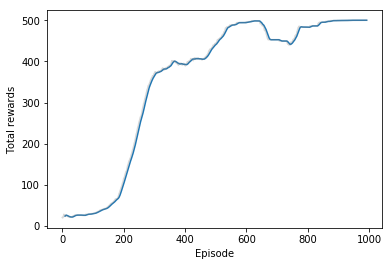

In [41]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

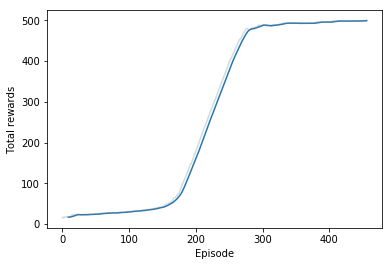

In [19]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

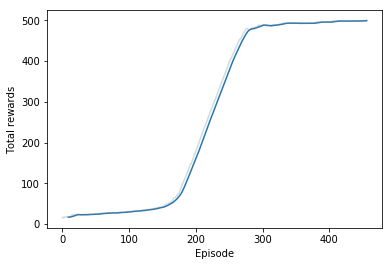

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

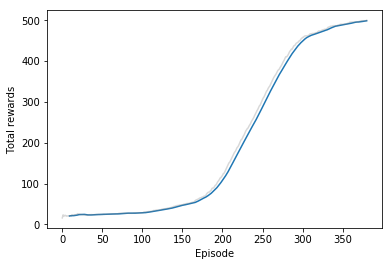

In [59]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

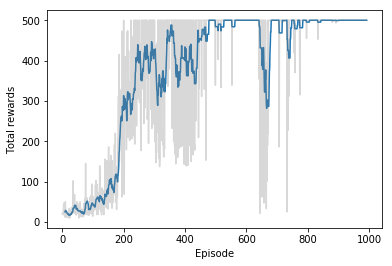

In [42]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

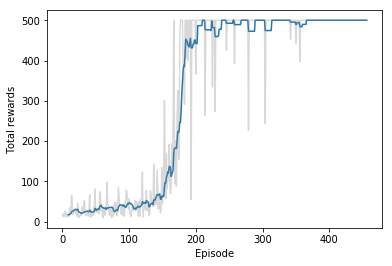

In [20]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

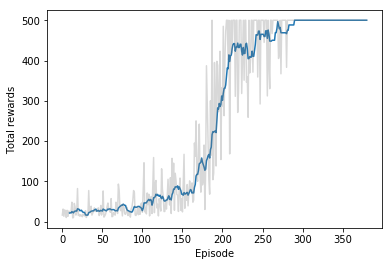

In [61]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [22]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(11):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.